# Imports

In [156]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_log_error
from sklearn.decomposition import PCA
import lightgbm as lgb
import xgboost as xgb
import joblib

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load DataFrames

In [85]:
transactions = pd.read_csv('/content/drive/My Drive/coe602/transactions.csv')
holidays_events = pd.read_csv('/content/drive/My Drive/coe602/holidays_events.csv')
oil = pd.read_csv('/content/drive/My Drive/coe602/oil.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/coe602/sample_submission.csv')
stores = pd.read_csv('/content/drive/My Drive/coe602/stores.csv')
test = pd.read_csv('/content/drive/My Drive/coe602/test.csv')
train = pd.read_csv('/content/drive/My Drive/coe602/train.csv')

In [86]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


# Global Variables

# Manipulating df

### Pra criar o data set

In [ ]:
# Converter as colunas 'date' para datetime
train['date'] = pd.to_datetime(train['date'], errors='coerce')
holidays_events['date'] = pd.to_datetime(holidays_events['date'], errors='coerce')
transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
oil['date'] = pd.to_datetime(oil['date'], errors='coerce')

# Remover feriados transferidos (manter apenas as datas finais)
holidays_events = holidays_events[holidays_events['transferred'] != True]

holidays_events.head()


NameError: name 'train' is not defined

In [ ]:
# Verificar os valores únicos das colunas
print("Valores únicos da coluna 'locale':", holidays_events['locale'].unique())
print("Valores únicos da coluna 'locale_name':", holidays_events['locale_name'].unique())
print("Valores únicos da coluna 'types':", holidays_events['type'].unique())
print("Valores únicos da coluna 'city':", stores['city'].unique())
print("Valores únicos da coluna 'state':", stores['state'].unique())
stores.head()


NameError: name 'holidays_events' is not defined

In [ ]:
locale_names = set(holidays_events['locale_name'].unique())
cities = set(stores['city'].unique())
states = set(stores['state'].unique())

# Identificar valores que estão em 'locale_name' mas não em 'city'
locale_not_in_city = locale_names - cities
# Identificar valores que estão em 'city' mas não em 'locale_name'
states_not_in_locale = states - locale_names
city_not_in_locale = cities - locale_names
city_not_in_locale, states_not_in_locale

In [ ]:
# Separar os holidays em Local, Regional e National
local_holidays = holidays_events[holidays_events['locale'] == 'Local']
regional_holidays = holidays_events[holidays_events['locale'] == 'Regional']
national_holidays = holidays_events[holidays_events['locale'] == 'National']

# Usar .loc para evitar SettingWithCopyWarning
national_holidays = national_holidays.copy()
national_holidays.loc[:,'key'] = 1

# Mesclar train com stores usando store_nbr
train_stores_merged = pd.merge(train, stores, on='store_nbr', how='left')
train_stores_merged.loc[:,	'key'] = 1

merged = pd.merge(train_stores_merged, national_holidays, on=['date','key'], how='left').drop('key', axis=1)
merged.rename(columns={'type_x': 'type_store', 'type_y': 'type_holiday'}, inplace=True)
merged = pd.merge(merged, local_holidays, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
merged = pd.merge(merged, regional_holidays, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')
merged.drop(['type_x', 'type_y','transferred', 'locale_name'], axis=1, inplace=True)

# Preencher os valores ausentes nas colunas de feriados
merged.drop(['transferred_x','locale_y','locale_name_y','description_y','transferred_y','locale','description', 'locale_name_x'], axis=1, inplace=True)
merged.rename(columns={'locale_x': 'locale', 'description_x': 'description'}, inplace=True)

merged.fillna({'locale':'No Locale'}, inplace=True)
merged.fillna({'description':'No Description'}, inplace=True)
merged.fillna({'type_holiday':'No holiday'}, inplace=True)


merged.to_csv('merged.csv', index=False)

In [ ]:
# Ajeitando dataset oleo
oil = pd.read_csv('oil.csv')
oil['date'] = pd.to_datetime(oil['date'], errors='coerce')
# Create a complete date range from the minimum to the maximum date in the dataset
date_range = pd.date_range(start=oil['date'].min(), end=oil['date'].max())

# Create a new DataFrame with the complete date range
complete_dates = pd.DataFrame(date_range, columns=['date'])

# Merge the complete date range with the original data
complete_oil_data = pd.merge(complete_dates, oil, on='date', how='left')

# Interpolate the missing values in the 'dcoilwtico' column
complete_oil_data['dcoilwtico'] = complete_oil_data['dcoilwtico'].interpolate(method='linear')
complete_oil_data.loc[0,'dcoilwtico'] = 93.00


print(complete_oil_data.isna().sum())
print(complete_oil_data.head())
print(len(oil), len(complete_oil_data), len(complete_dates))

In [ ]:
transactions = pd.read_csv('transactions.csv')
transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
merged_2 = pd.merge(merged, complete_oil_data, on='date', how='left')
merged_2 = pd.merge(merged_2, transactions, on=['store_nbr', 'date'], how='left')

# merged_2.fillna({'transcations':0}, inplace=True)
merged_2['transactions'] = merged_2['transactions'].fillna(0)

merged_2.to_csv('merged_2.csv', index=False)

# Verificar a presença de NaNs após o merge
print("Número de NaNs no dataframe merged_data após o merge:")
print(merged_2.isna().sum())

# Identificar as linhas com NaNs na coluna transactions
nans_after_merge = merged_2[merged_2['transactions'].isna()]
print("Linhas com NaNs na coluna transactions após o merge:")
print(nans_after_merge)

merged_data = merged_2.copy()

### Só chamar o arquivo do dataset unido

In [90]:
path_merged_data = '/content/drive/MyDrive/coe602/merged_2.csv'
merged_data = pd.read_csv(path_merged_data)

data = merged_data.copy()


path_merged_test = '/content/drive/MyDrive/coe602/merged_test.csv'
merged_test = pd.read_csv(path_merged_test)

test = merged_test.copy()

In [8]:
test.tail()

,id,date,store_nbr,family,onpromotion,city,state,type_store,cluster,type_holiday,locale,description,dcoilwtico,transactions
28507,3029395,2017-08-31,9,POULTRY,1,Quito,Pichincha,B,6,No holiday,No Locale,No Description,47.26,0.0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,Quito,Pichincha,B,6,No holiday,No Locale,No Description,47.26,0.0
28509,3029397,2017-08-31,9,PRODUCE,1,Quito,Pichincha,B,6,No holiday,No Locale,No Description,47.26,0.0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,Quito,Pichincha,B,6,No holiday,No Locale,No Description,47.26,0.0
28511,3029399,2017-08-31,9,SEAFOOD,0,Quito,Pichincha,B,6,No holiday,No Locale,No Description,47.26,0.0


### Test Data

In [ ]:
## test data

# Separar os holidays em Local, Regional e National
local_holidays = holidays_events[holidays_events['locale'] == 'Local']
regional_holidays = holidays_events[holidays_events['locale'] == 'Regional']
national_holidays = holidays_events[holidays_events['locale'] == 'National']

# Usar .loc para evitar SettingWithCopyWarning
national_holidays = national_holidays.copy()
national_holidays.loc[:,'key'] = 1

# Mesclar test com stores usando store_nbr
test_stores_merged = pd.merge(test, stores, on='store_nbr', how='left')
test_stores_merged.loc[:,	'key'] = 1

merged = pd.merge(test_stores_merged, national_holidays, on=['date','key'], how='left').drop('key', axis=1)
merged.rename(columns={'type_x': 'type_store', 'type_y': 'type_holiday'}, inplace=True)
merged = pd.merge(merged, local_holidays, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
merged = pd.merge(merged, regional_holidays, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')
merged.drop(['type_x', 'type_y','transferred', 'locale_name'], axis=1, inplace=True)

# Preencher os valores ausentes nas colunas de feriados
merged.drop(['transferred_x','locale_y','locale_name_y','description_y','transferred_y','locale','description', 'locale_name_x'], axis=1, inplace=True)
merged.rename(columns={'locale_x': 'locale', 'description_x': 'description'}, inplace=True)

merged.fillna({'locale':'No Locale'}, inplace=True)
merged.fillna({'description':'No Description'}, inplace=True)
merged.fillna({'type_holiday':'No holiday'}, inplace=True)


# Ajeitando dataset oleo
oil['date'] = pd.to_datetime(oil['date'], errors='coerce')
# Create a complete date range from the minimum to the maximum date in the dataset
date_range = pd.date_range(start=oil['date'].min(), end=oil['date'].max())

# Create a new DataFrame with the complete date range
complete_dates = pd.DataFrame(date_range, columns=['date'])

# Merge the complete date range with the original data
complete_oil_data = pd.merge(complete_dates, oil, on='date', how='left')

# Interpolate the missing values in the 'dcoilwtico' column
complete_oil_data['dcoilwtico'] = complete_oil_data['dcoilwtico'].interpolate(method='linear')
complete_oil_data.loc[0,'dcoilwtico'] = 93.00


print(complete_oil_data.isna().sum())
print(complete_oil_data.head())
print(len(oil), len(complete_oil_data), len(complete_dates))


transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
merged['date'] = pd.to_datetime(merged['date'], errors='coerce')
merged_2 = pd.merge(merged, complete_oil_data, on='date', how='left')
merged_2 = pd.merge(merged_2, transactions, on=['store_nbr', 'date'], how='left')

# merged_2.fillna({'transcations':0}, inplace=True)
merged_2['transactions'] = merged_2['transactions'].fillna(0)

merged_2.to_csv('merged_test.csv', index=False)
files.download('merged_test.csv')


# Infos

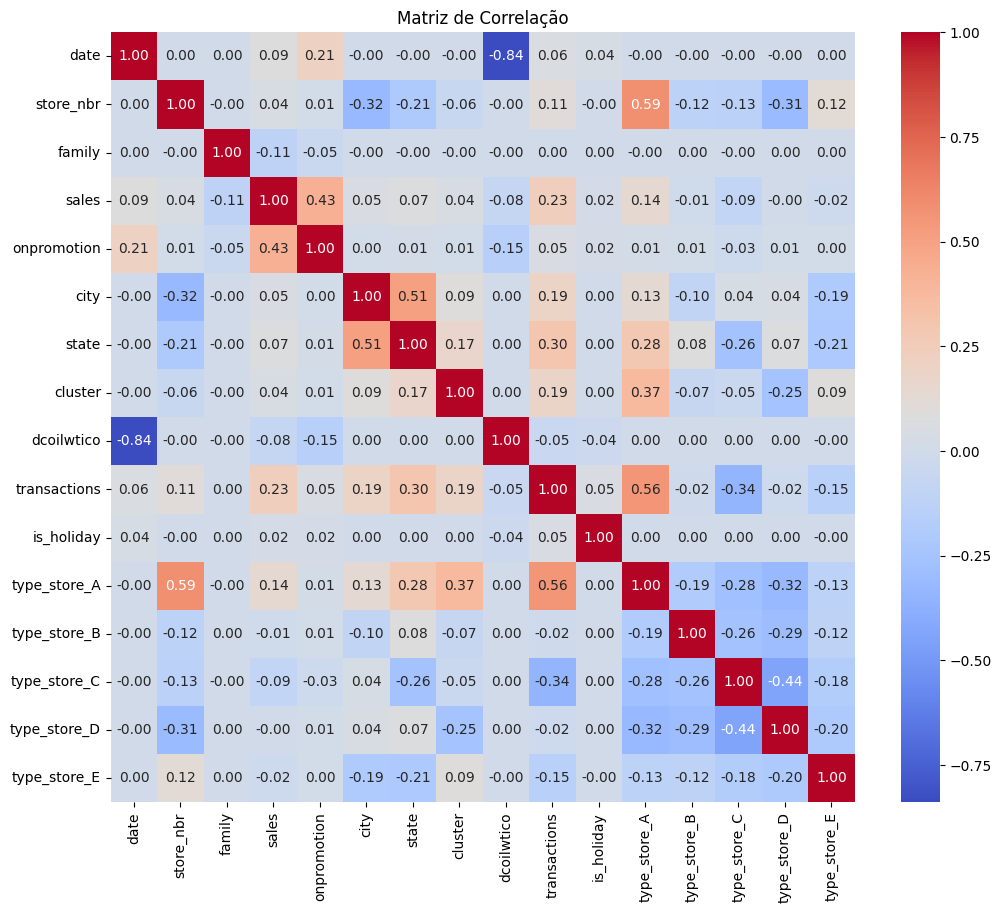

In [ ]:
path_merged_data = 'drive/MyDrive/coe602/merged_2.csv'
merged_data = pd.read_csv(path_merged_data)
data = merged_data.copy()

data['date'] = pd.to_datetime(data['date'], errors='coerce')
data.drop(['id'], axis=1, inplace=True)

# Converter colunas categóricas específicas para one-hot encoding
columns_to_encode = ['type_store']
data = pd.get_dummies(data, columns=columns_to_encode)

# Converter colunas categóricas para valores numéricos
label_encoders = {}
for column in data.select_dtypes(include=[object]).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Criar características de data
data['date'] = pd.to_datetime(data['date'])

# Calcular a matriz de correlação
correlation_matrix = data.corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação')
plt.show()

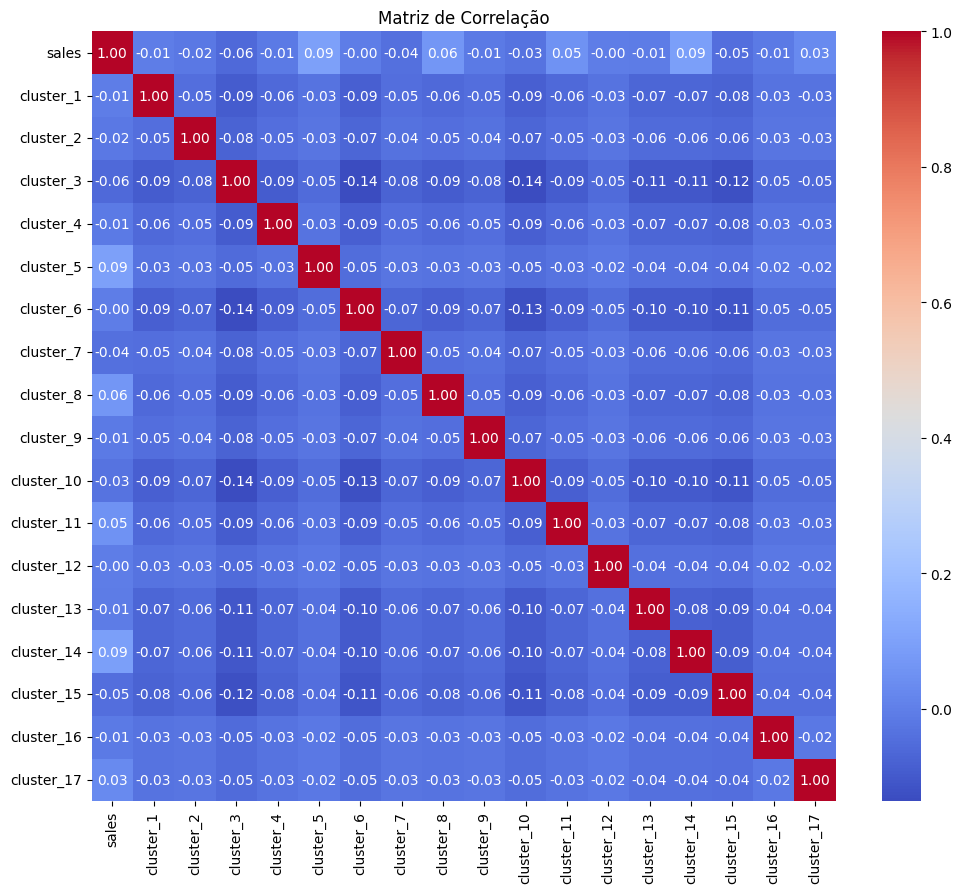

In [ ]:
cluster_sales_df = data[['cluster', 'sales']]

# Converter colunas categóricas específicas para one-hot encoding
columns_to_encode = ['cluster']
cluster_sales_df = pd.get_dummies(cluster_sales_df, columns=columns_to_encode)

# Converter colunas categóricas para valores numéricos
label_encoders = {}
for column in cluster_sales_df.select_dtypes(include=[object]).columns:
    label_encoders[column] = LabelEncoder()
    cluster_sales_df[column] = label_encoders[column].fit_transform(cluster_sales_df[column])

# Calcular a matriz de correlação
correlation_matrix = cluster_sales_df.corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação')
plt.show()

# Plots

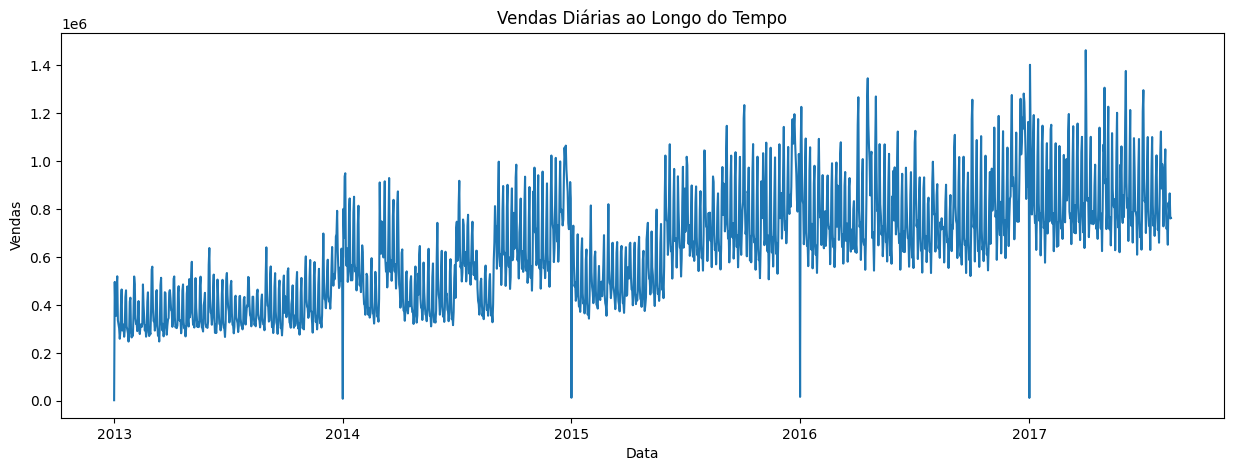

In [ ]:
import matplotlib.pyplot as plt

# Configurar o tamanho do gráfico
plt.figure(figsize=(15, 5))

# Gráfico: Vendas ao longo do tempo
train['date'] = pd.to_datetime(train['date'])
daily_sales = train.groupby('date')['sales'].sum()
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Vendas Diárias ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Vendas')

# Mostrar o gráfico
plt.show()


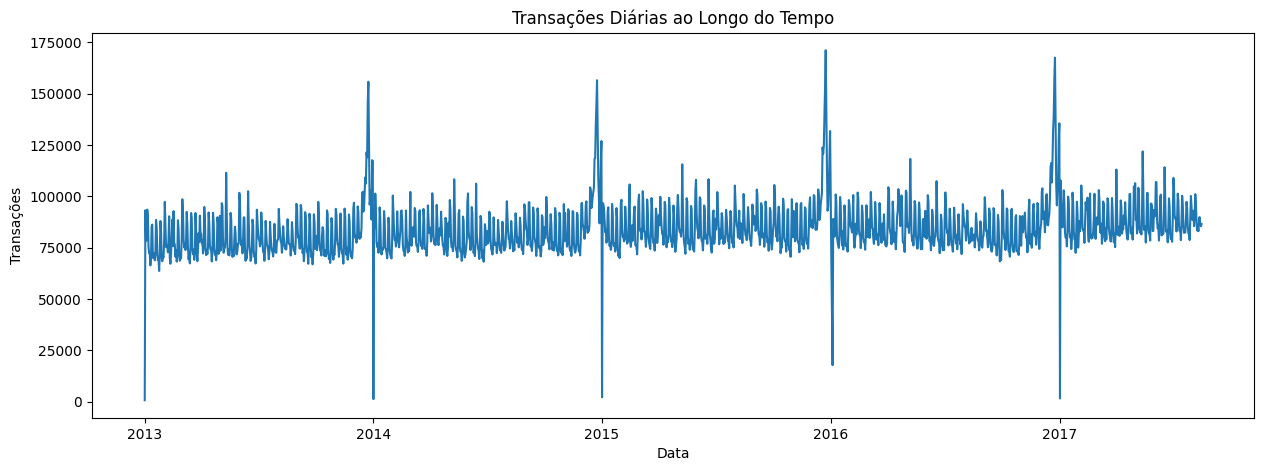

In [ ]:
# Configurar o tamanho do gráfico
plt.figure(figsize=(15, 5))

# Gráfico: Transações ao longo do tempo
transactions['date'] = pd.to_datetime(transactions['date'])
daily_transactions = transactions.groupby('date')['transactions'].sum()
plt.plot(daily_transactions.index, daily_transactions.values)
plt.title('Transações Diárias ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Transações')

# Mostrar o gráfico
plt.show()

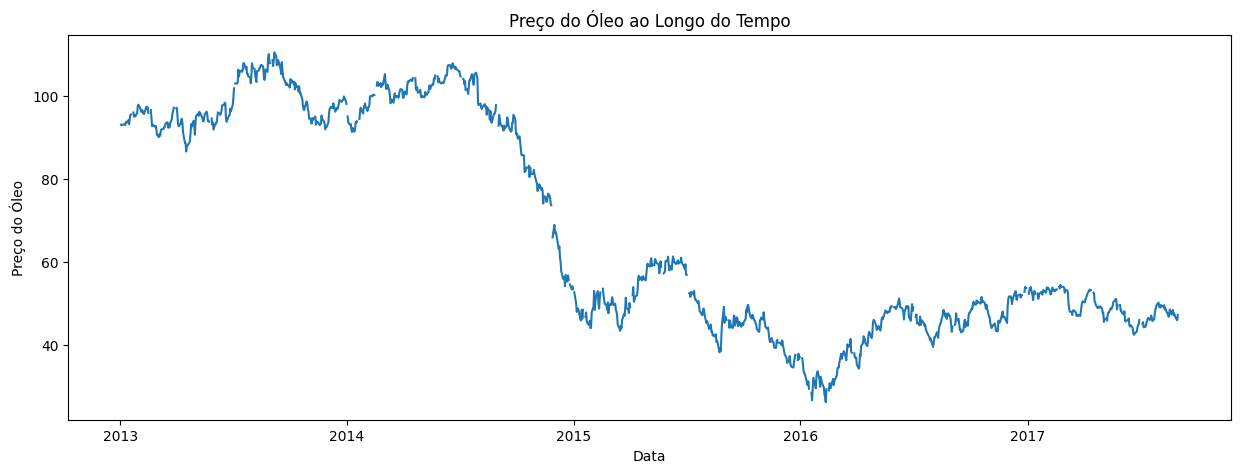

In [ ]:
# Configurar o tamanho do gráfico
plt.figure(figsize=(15, 5))

# Gráfico: Preço do óleo ao longo do tempo
oil['date'] = pd.to_datetime(oil['date'])
plt.plot(oil['date'], oil['dcoilwtico'])
plt.title('Preço do Óleo ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço do Óleo')

# Mostrar o gráfico
plt.show()

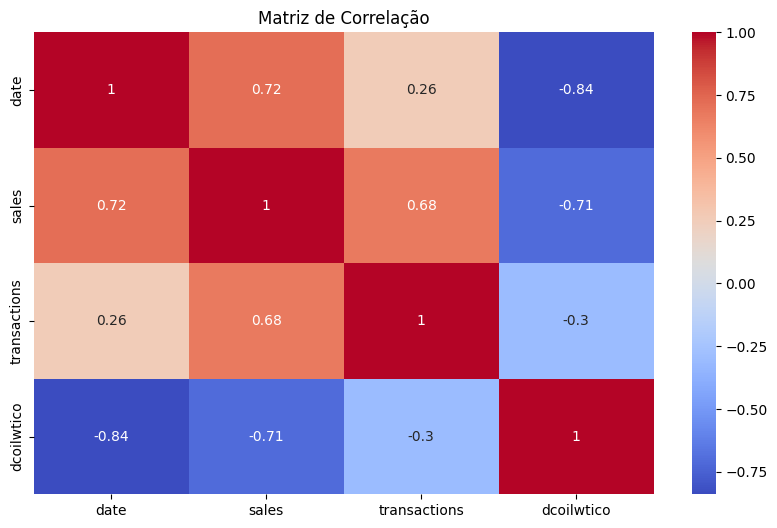

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados (assegure-se de que os arquivos estão no mesmo diretório ou ajuste os caminhos)
train = pd.read_csv('train.csv')
transactions = pd.read_csv('transactions.csv')
oil = pd.read_csv('oil.csv')



# Agrupar as vendas e transações diárias
daily_sales = train.groupby('date')['sales'].sum().reset_index()
daily_transactions = transactions.groupby('date')['transactions'].sum().reset_index()

# Combinar os datasets
combined = pd.merge(daily_sales, daily_transactions, on='date', how='left')
combined = pd.merge(combined, oil, on='date', how='left')

# Calcular a matriz de correlação
correlation_matrix = combined.corr()

# Plotar o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


In [ ]:
import seaborn as sns

# Agrupar as vendas e transações diárias
daily_sales = train.groupby('date')['sales'].sum().reset_index()
daily_transactions = transactions.groupby('date')['transactions'].sum().reset_index()

# Combinar os datasets
combined = pd.merge(daily_sales, daily_transactions, on='date', how='left')
combined = pd.merge(combined, oil, on='date', how='left')

# Calcular a matriz de correlação
correlation_matrix = combined.corr()

# Mostrar a matriz de correlação
correlation_matrix


,date,sales,transactions,dcoilwtico
date,1.000000,0.718394,0.258037,-0.839544
sales,0.718394,1.000000,0.676509,-0.705002
transactions,0.258037,0.676509,1.000000,-0.303674
dcoilwtico,-0.839544,-0.705002,-0.303674,1.000000


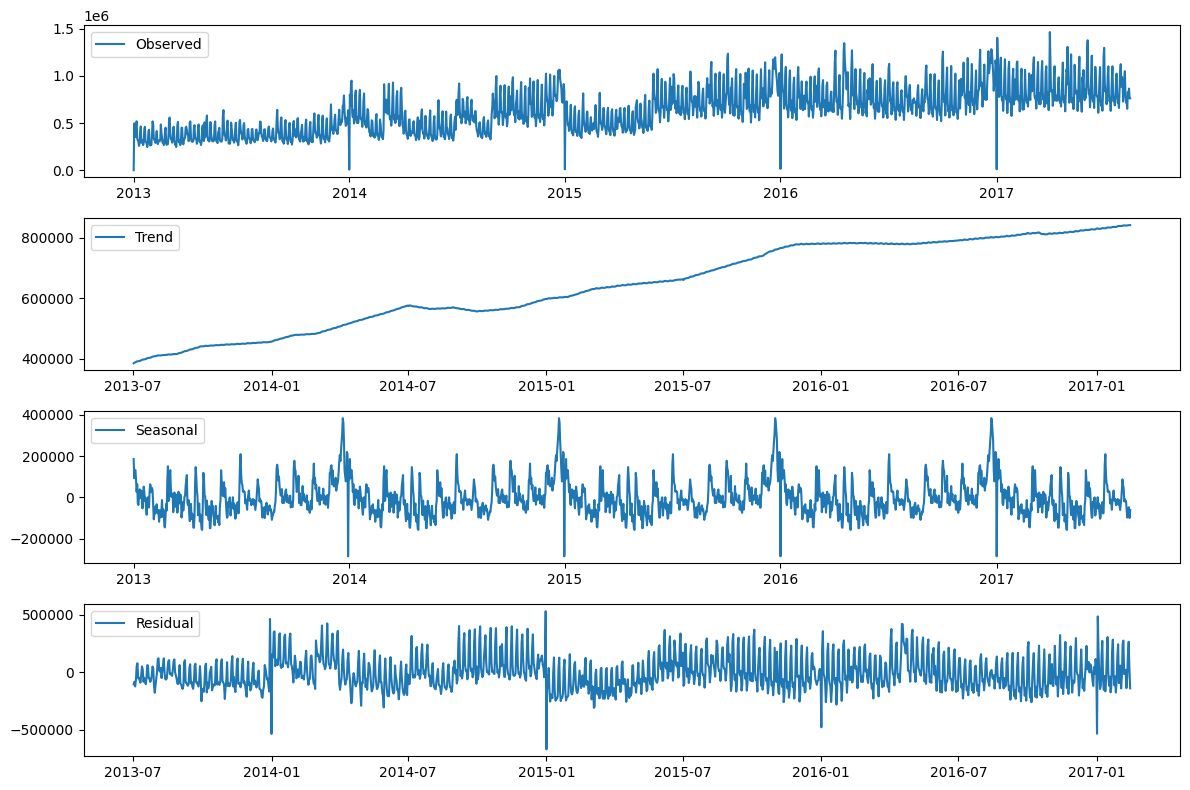

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Converter a coluna 'date' para datetime
train['date'] = pd.to_datetime(train['date'])

# Agrupar as vendas diárias
daily_sales = train.groupby('date')['sales'].sum()

# Decomposição sazonal
decomposition = seasonal_decompose(daily_sales, model='additive', period=365)

# Plotar os componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


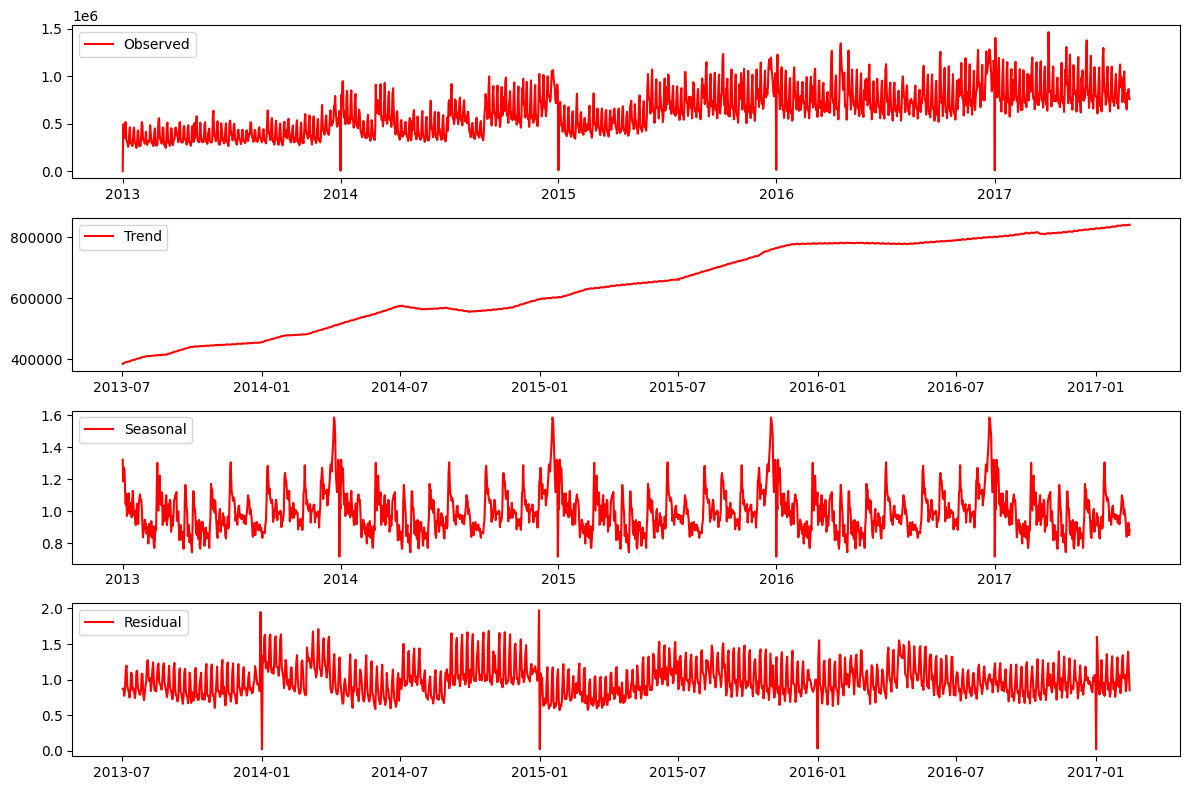

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# Converter a coluna 'date' para datetime
train['date'] = pd.to_datetime(train['date'])

# Agrupar as vendas diárias
daily_sales = train.groupby('date')['sales'].sum()

# Decomposição sazonal multiplicativa
decomposition = seasonal_decompose(daily_sales, model='multiplicative', period=365)

# Plotar os componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color="red")
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color="red")
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color="red")
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color="red")
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


## Vendas por lojas

In [ ]:
# Agrupar as vendas por loja
sales_by_store = train.groupby('store_nbr')['sales'].sum().reset_index()
sales_by_store = sales_by_store.sort_values(by='sales', ascending=False)

# Mostrar os dados agrupados
sales_by_store.head()


,store_nbr,sales
43,44,6.208755e+07
44,45,5.449801e+07
46,47,5.094831e+07
2,3,5.048191e+07
48,49,4.342010e+07


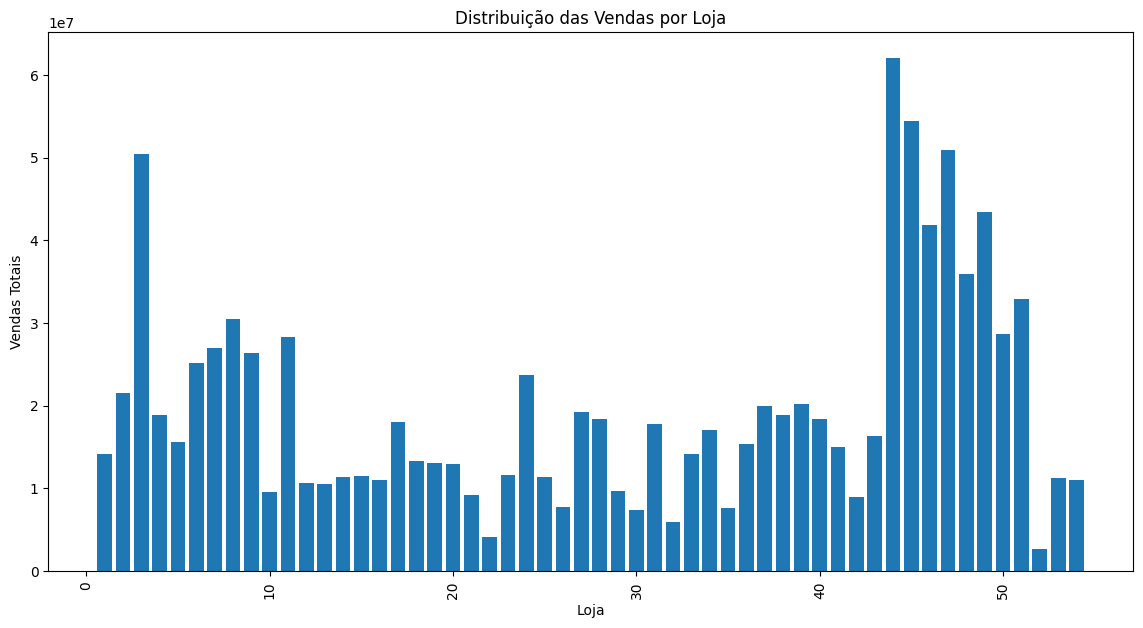

In [ ]:
import matplotlib.pyplot as plt

# Plotar a distribuição das vendas por loja
plt.figure(figsize=(14, 7))
plt.bar(sales_by_store['store_nbr'], sales_by_store['sales'])
plt.title('Distribuição das Vendas por Loja')
plt.xlabel('Loja')
plt.ylabel('Vendas Totais')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Estatísticas descritivas por loja
sales_stats_by_store = train.groupby('store_nbr')['sales'].describe()

# Mostrar as estatísticas descritivas
sales_stats_by_store.head()


,count,mean,std,min,25%,50%,75%,max
store_nbr,,,,,,,,
1,55572.0,254.534889,596.827146,0.0,1.0,19.000,166.000,9065.00
2,55572.0,387.918172,1079.560490,0.0,2.0,23.217,291.000,124717.00
3,55572.0,908.405495,2146.185033,0.0,4.0,64.000,586.000,21858.00
4,55572.0,340.273886,801.128208,0.0,1.0,19.000,257.128,8969.00
5,55572.0,280.580231,652.588149,0.0,1.0,19.000,237.000,8216.62


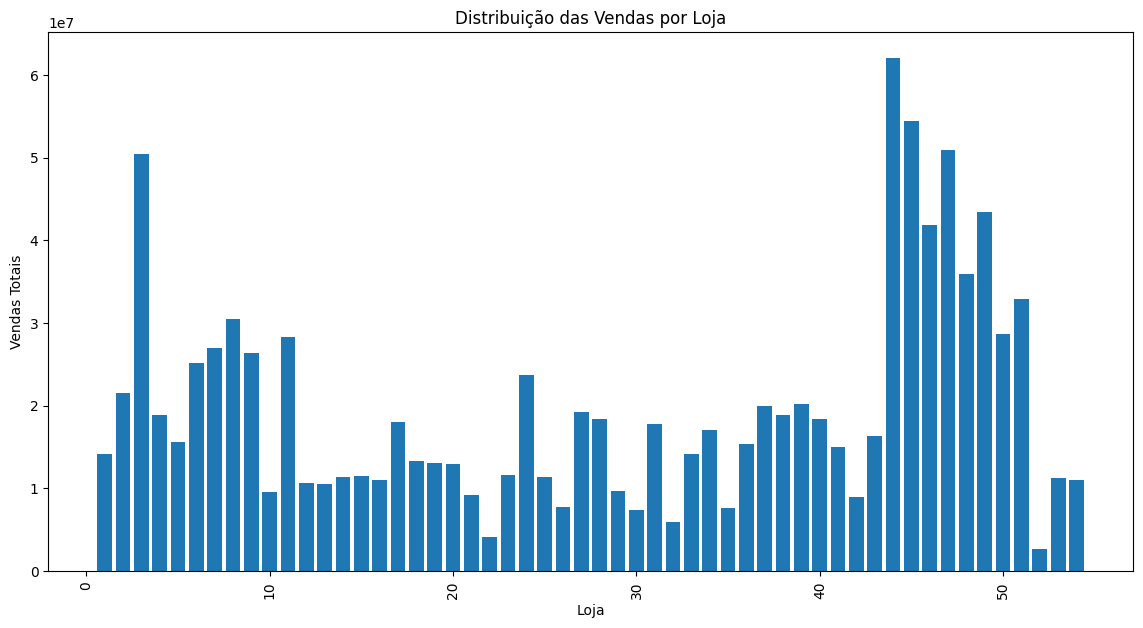

             count        mean          std  min  25%     50%      75%  \
store_nbr                                                                
1          55572.0  254.534889   596.827146  0.0  1.0  19.000  166.000   
2          55572.0  387.918172  1079.560490  0.0  2.0  23.217  291.000   
3          55572.0  908.405495  2146.185033  0.0  4.0  64.000  586.000   
4          55572.0  340.273886   801.128208  0.0  1.0  19.000  257.128   
5          55572.0  280.580231   652.588149  0.0  1.0  19.000  237.000   

                 max  
store_nbr             
1            9065.00  
2          124717.00  
3           21858.00  
4            8969.00  
5            8216.62  


In [ ]:
# Agrupar as vendas por loja
sales_by_store = train.groupby('store_nbr')['sales'].sum().reset_index()
sales_by_store = sales_by_store.sort_values(by='sales', ascending=False)

# Plotar a distribuição das vendas por loja
plt.figure(figsize=(14, 7))
plt.bar(sales_by_store['store_nbr'], sales_by_store['sales'])
plt.title('Distribuição das Vendas por Loja')
plt.xlabel('Loja')
plt.ylabel('Vendas Totais')
plt.xticks(rotation=90)
plt.show()

# Estatísticas descritivas por loja
sales_stats_by_store = train.groupby('store_nbr')['sales'].describe()

# Mostrar as estatísticas descritivas
print(sales_stats_by_store.head())

## Feriados e vendas

           Non-Holiday     Holiday     Impact
store_nbr                                    
1           255.599781  249.894706  -2.232034
2           378.589426  448.225570  18.393579
3           898.638772  977.990976   8.830267
4           335.784268  370.862155  10.446555
5           277.215174  302.666478   9.181065


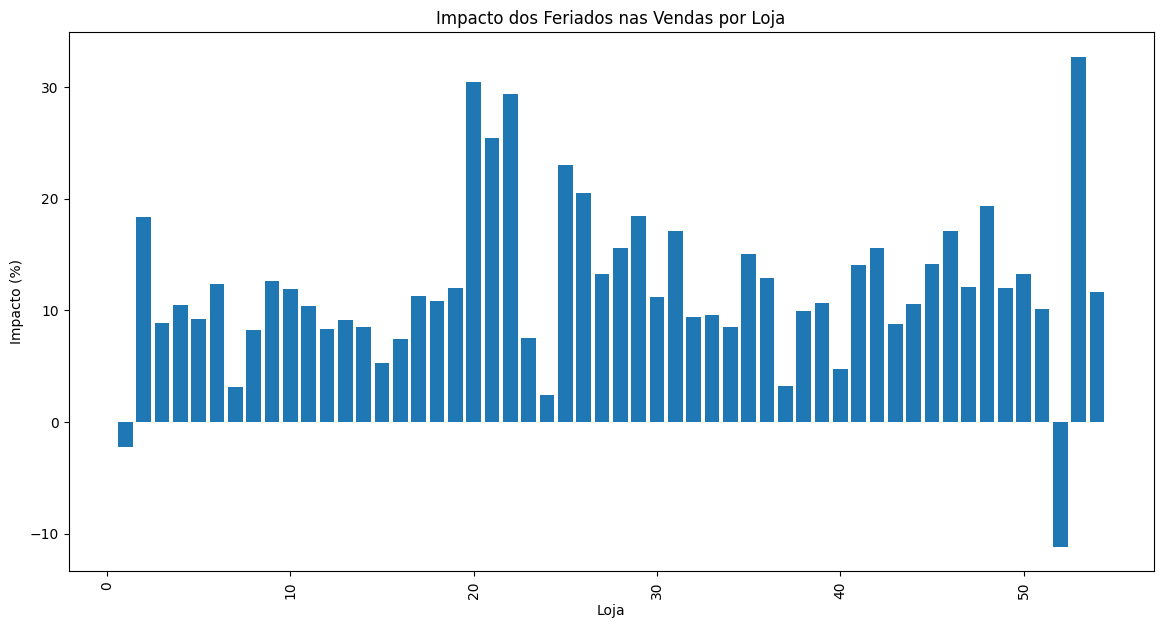

In [ ]:
# Calcular as vendas médias em feriados e dias normais por loja
average_sales_by_store = train.groupby(['store_nbr', 'is_holiday'])['sales'].mean().unstack()
average_sales_by_store.columns = ['Non-Holiday', 'Holiday']
average_sales_by_store['Impact'] = (average_sales_by_store['Holiday'] - average_sales_by_store['Non-Holiday']) / average_sales_by_store['Non-Holiday'] * 100

print(average_sales_by_store.head())

# Plotar o impacto dos feriados nas vendas por loja
plt.figure(figsize=(14, 7))
plt.bar(average_sales_by_store.index, average_sales_by_store['Impact'])
plt.title('Impacto dos Feriados nas Vendas por Loja')
plt.xlabel('Loja')
plt.ylabel('Impacto (%)')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Calcular a correlação entre os preços do petróleo e as vendas
train = pd.merge(train, oil, on='date', how='left')
correlation = train[['sales', 'dcoilwtico']].corr()
print(correlation)

# Calcular as vendas médias em diferentes níveis de preços do petróleo
train['oil_price_bin'] = pd.cut(train['dcoilwtico'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Calcular as vendas médias por bin de preço do petróleo
average_sales_by_oil_price = train.groupby('oil_price_bin')['sales'].mean()

# Mostrar as vendas médias por bin de preço do petróleo
average_sales_by_oil_price

               sales  dcoilwtico
sales       1.000000   -0.079393
dcoilwtico -0.079393    1.000000


oil_price_bin
Very Low     406.461694
Low          382.514641
Medium       340.473519
High         253.239861
Very High    222.326181
Name: sales, dtype: float64

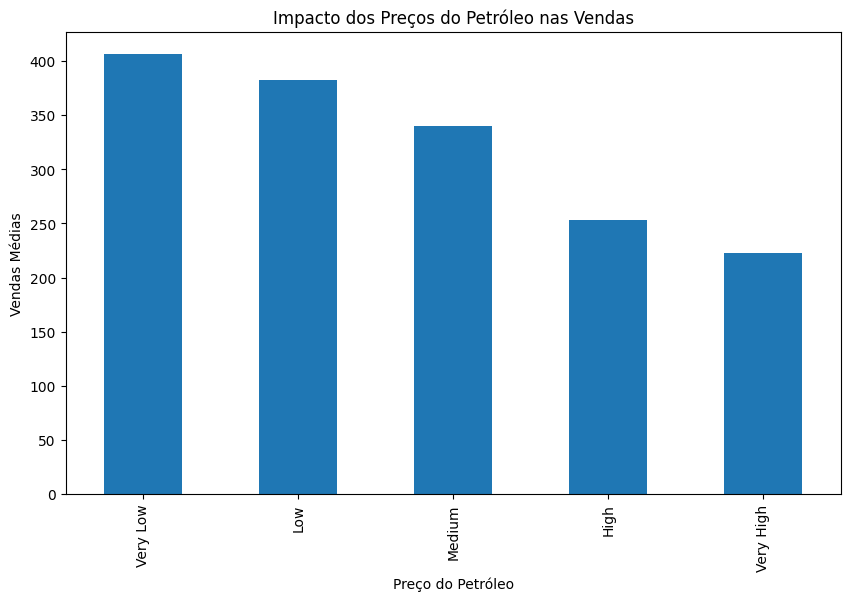

In [ ]:
plt.figure(figsize=(10, 6))
average_sales_by_oil_price.plot(kind='bar')
plt.title('Impacto dos Preços do Petróleo nas Vendas')
plt.xlabel('Preço do Petróleo')
plt.ylabel('Vendas Médias')
plt.show()

In [ ]:

# Juntar os dados de vendas com os dados de lojas
train = pd.merge(train, stores, on='store_nbr', how='left')

# Juntar os dados de vendas com os dados de transações
train = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')

# Mostrar as primeiras linhas do dataset combinado
train.head()

,id,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,is_holiday,dcoilwtico,oil_price_bin,city,state,type_y,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,True,NaN,NaN,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,True,NaN,NaN,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,True,NaN,NaN,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,True,NaN,NaN,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,True,NaN,NaN,Quito,Pichincha,D,13,NaN


In [ ]:
# Calcular a correlação entre as variáveis de interesse
correlation_matrix = train[['sales', 'dcoilwtico', 'transactions', 'cluster']].corr()
print(correlation_matrix)

# Calcular as vendas médias por cluster de loja
average_sales_by_cluster = train.groupby('cluster')['sales'].mean()

# Mostrar as vendas médias por cluster de loja
average_sales_by_cluster

                 sales    dcoilwtico  transactions       cluster
sales         1.000000 -7.939345e-02      0.214837  3.853457e-02
dcoilwtico   -0.079393  1.000000e+00      0.018664 -4.187239e-14
transactions  0.214837  1.866365e-02      1.000000  1.961087e-01
cluster       0.038535 -4.187239e-14      0.196109  1.000000e+00


cluster
1      326.991022
2      260.976207
3      194.888611
4      297.495704
5     1119.908466
6      344.224523
7      139.754934
8      648.876383
9      275.668398
10     256.953989
11     605.691523
12     325.495236
13     325.719221
14     710.758710
15     199.446381
16     239.537100
17     594.108258
Name: sales, dtype: float64

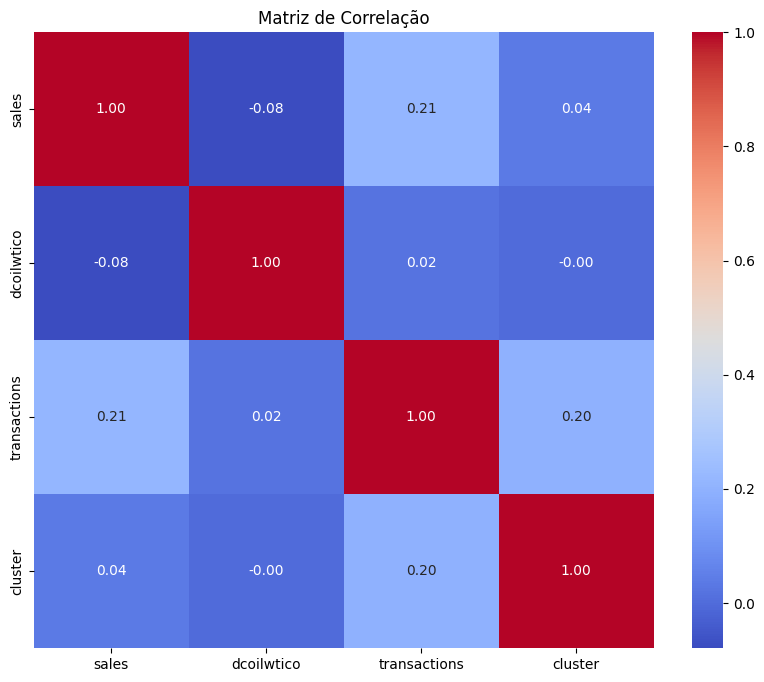

In [ ]:
import seaborn as sns

# Calcular a correlação entre as variáveis de interesse
correlation_matrix = train[['sales', 'dcoilwtico', 'transactions', 'cluster']].corr()

# Plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

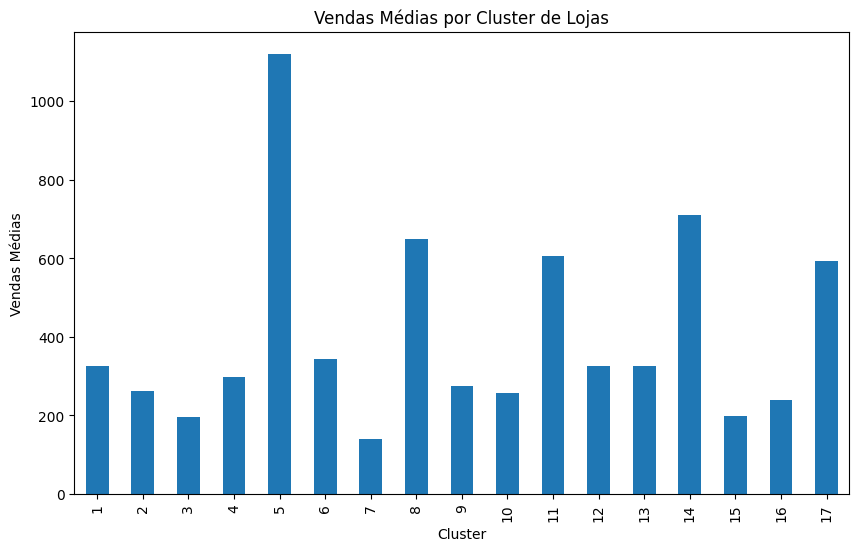

In [ ]:
# Plotar a relação entre cluster de lojas e vendas
plt.figure(figsize=(10, 6))
average_sales_by_cluster.plot(kind='bar')
plt.title('Vendas Médias por Cluster de Lojas')
plt.xlabel('Cluster')
plt.ylabel('Vendas Médias')
plt.show()

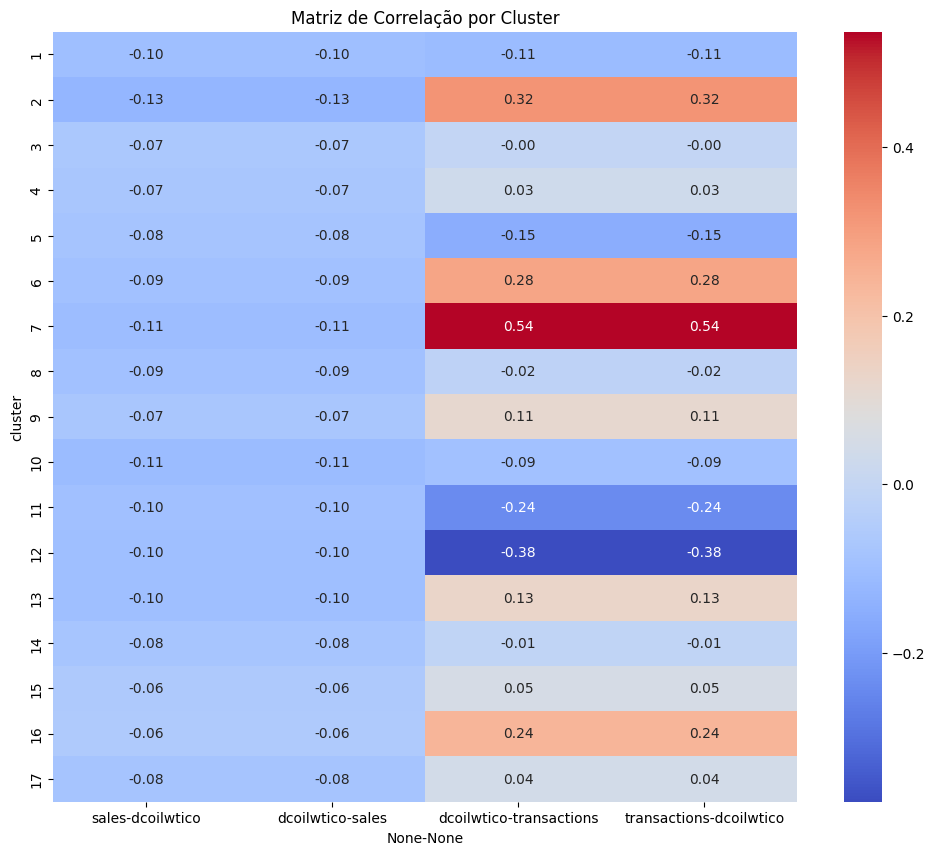

In [ ]:
# Calcular correlação por cluster
correlation_matrix_cluster = train.groupby('cluster')[['sales', 'dcoilwtico', 'transactions']].corr().unstack().iloc[:, 1::2]

# Plotar matriz de correlação por cluster
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_cluster, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação por Cluster')
plt.show()

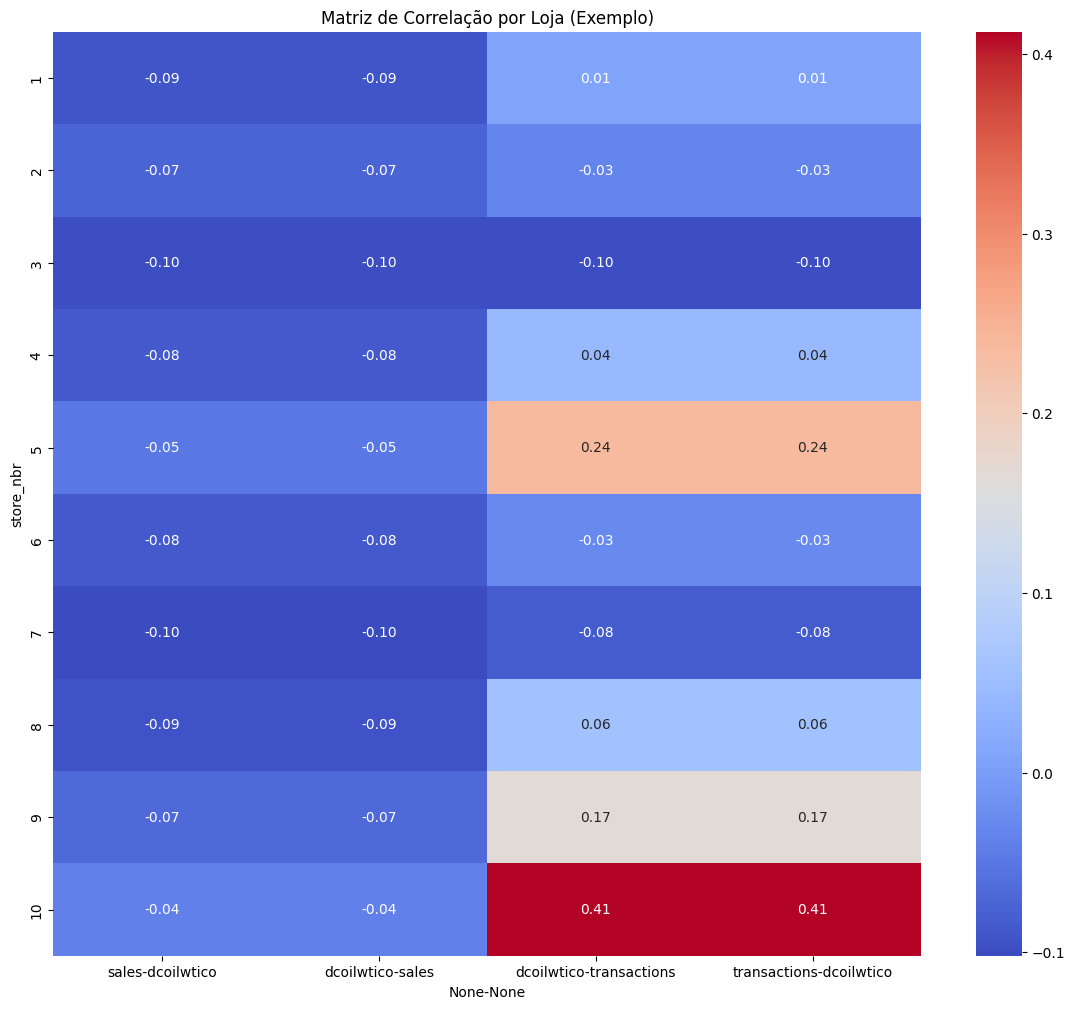

In [ ]:
correlation_matrix_store = train.groupby('store_nbr')[['sales', 'dcoilwtico', 'transactions']].corr().unstack().iloc[:, 1::2]

# Selecionar algumas lojas para exemplo
sample_stores = correlation_matrix_store.index.get_level_values(0).unique()[:10]
sample_correlation_matrix_store = correlation_matrix_store.loc[sample_stores]

# Plotar a matriz de correlação por loja (exemplo de algumas lojas)
plt.figure(figsize=(14, 12))
sns.heatmap(sample_correlation_matrix_store, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação por Loja (Exemplo)')
plt.show()


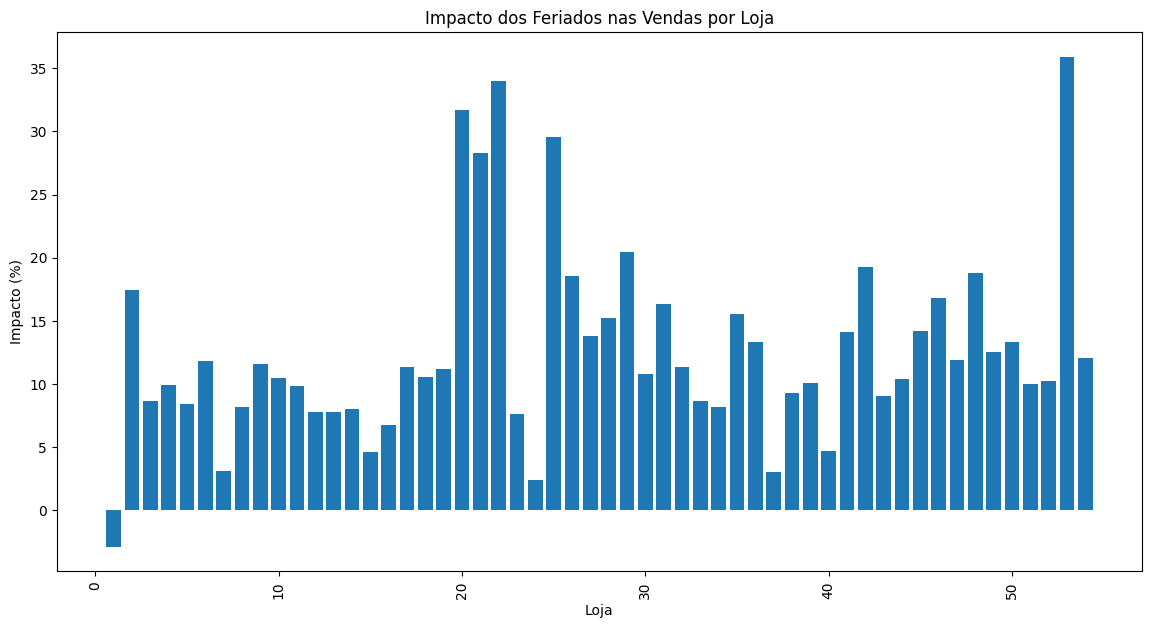

In [ ]:
import matplotlib.pyplot as plt

# Plotar o impacto dos feriados nas vendas por loja
plt.figure(figsize=(14, 7))
plt.bar(average_sales_by_store.index, average_sales_by_store['Impact'])
plt.title('Impacto dos Feriados nas Vendas por Loja')
plt.xlabel('Loja')
plt.ylabel('Impacto (%)')
plt.xticks(rotation=90)
plt.show()


# Feature eng

In [ ]:
def encode_categorical_data(df):
    # Get all column names
    columns = df.columns

    # Create a LabelEncoder object
    encoder = LabelEncoder()

    # Apply LabelEncoder to each column
    for col in columns:
        # Check if the column contains categorical data
        if df[col].dtype == 'object':
            # Encode the categorical data
            df[col] = encoder.fit_transform(df[col])

In [91]:
def add_lag_features(df, lags, target_col):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# Carregar os dados
train_data = data.copy()
test_data =test.copy()

# Supondo que a coluna 'sales' é o alvo e que 'Id' é a coluna de identificação
target = 'sales'
id_col = 'id'

# Combinar os conjuntos de dados de treino e teste
train_len = len(train_data)
combined_data = pd.concat([train_data, test_data], sort=False).reset_index(drop=True)

# Adicionar features de lag
lags = [14, 30, 60]  # Exemplos de lags
combined_data = add_lag_features(combined_data, lags, target)

# Lidar com valores ausentes após a adição de lags
# combined_data.fillna(combined_data.mean(numeric_only=True), inplace=True)

# Separar os conjuntos de dados de treino e teste novamente
train_data = combined_data.iloc[:train_len].copy()
test_data = combined_data.iloc[train_len:].copy()

# # Separar features e target no conjunto de treino
# X = train_data.drop(columns=[target, id_col])
# y = train_data[target]


In [92]:
train_data.to_csv('/content/drive/MyDrive/coe602/train_data_lag.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/coe602/test_data_lag.csv', index=False)

In [69]:
test_data

,id,store_nbr,family,sales,onpromotion,city,state,type_store,cluster,dcoilwtico,...,is_holiday,year,month,day,dayofweek,is_weekend,quarter,weekofyear,day_of_year,is_payday
0,3000888,1,0,358.264309,0,18,12,3,13,46.80,...,0,2017,8,16,2,0,3,33,228,False
1,3000889,1,1,358.264309,0,18,12,3,13,46.80,...,0,2017,8,16,2,0,3,33,228,False
2,3000890,1,2,358.264309,2,18,12,3,13,46.80,...,0,2017,8,16,2,0,3,33,228,False
3,3000891,1,3,358.264309,20,18,12,3,13,46.80,...,0,2017,8,16,2,0,3,33,228,False
4,3000892,1,4,358.264309,0,18,12,3,13,46.80,...,0,2017,8,16,2,0,3,33,228,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,9,28,358.264309,1,18,12,1,6,47.26,...,0,2017,8,31,3,0,3,35,243,True
28508,3029396,9,29,358.264309,0,18,12,1,6,47.26,...,0,2017,8,31,3,0,3,35,243,True
28509,3029397,9,30,358.264309,1,18,12,1,6,47.26,...,0,2017,8,31,3,0,3,35,243,True
28510,3029398,9,31,358.264309,9,18,12,1,6,47.26,...,0,2017,8,31,3,0,3,35,243,True


In [105]:
path_train_data = '/content/drive/MyDrive/coe602/train_data_lag.csv'
train = pd.read_csv(path_train_data)

train_data = train.copy()


path_test_data = '/content/drive/MyDrive/coe602/test_data_lag.csv'
test = pd.read_csv(path_test_data)

test_data = test.copy()

In [4]:
from pandas.tseries.offsets import MonthEnd

# Função para determinar se uma data é dia de pagamento
def is_payday(date):
    return (date.day == 15) or (date == date + MonthEnd(0))

# Supondo que 'date' seja a coluna de datas no seu conjunto de dados
date_col = 'date'



In [111]:
test_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster,type_holiday,locale,description,dcoilwtico,transactions,sales_lag_14,sales_lag_30,sales_lag_60
0,3000888,2017-08-16,1,AUTOMOTIVE,NaN,0,Quito,Pichincha,D,13,No holiday,No Locale,No Description,46.8,0.0,10.0,3530.0,13.000
1,3000889,2017-08-16,1,BABY CARE,NaN,0,Quito,Pichincha,D,13,No holiday,No Locale,No Description,46.8,0.0,11.0,0.0,1198.000
2,3000890,2017-08-16,1,BEAUTY,NaN,2,Quito,Pichincha,D,13,No holiday,No Locale,No Description,46.8,0.0,6.0,528.0,1330.000
3,3000891,2017-08-16,1,BEVERAGES,NaN,20,Quito,Pichincha,D,13,No holiday,No Locale,No Description,46.8,0.0,25.0,16.0,276.639
4,3000892,2017-08-16,1,BOOKS,NaN,0,Quito,Pichincha,D,13,No holiday,No Locale,No Description,46.8,0.0,11.0,1439.0,298.000


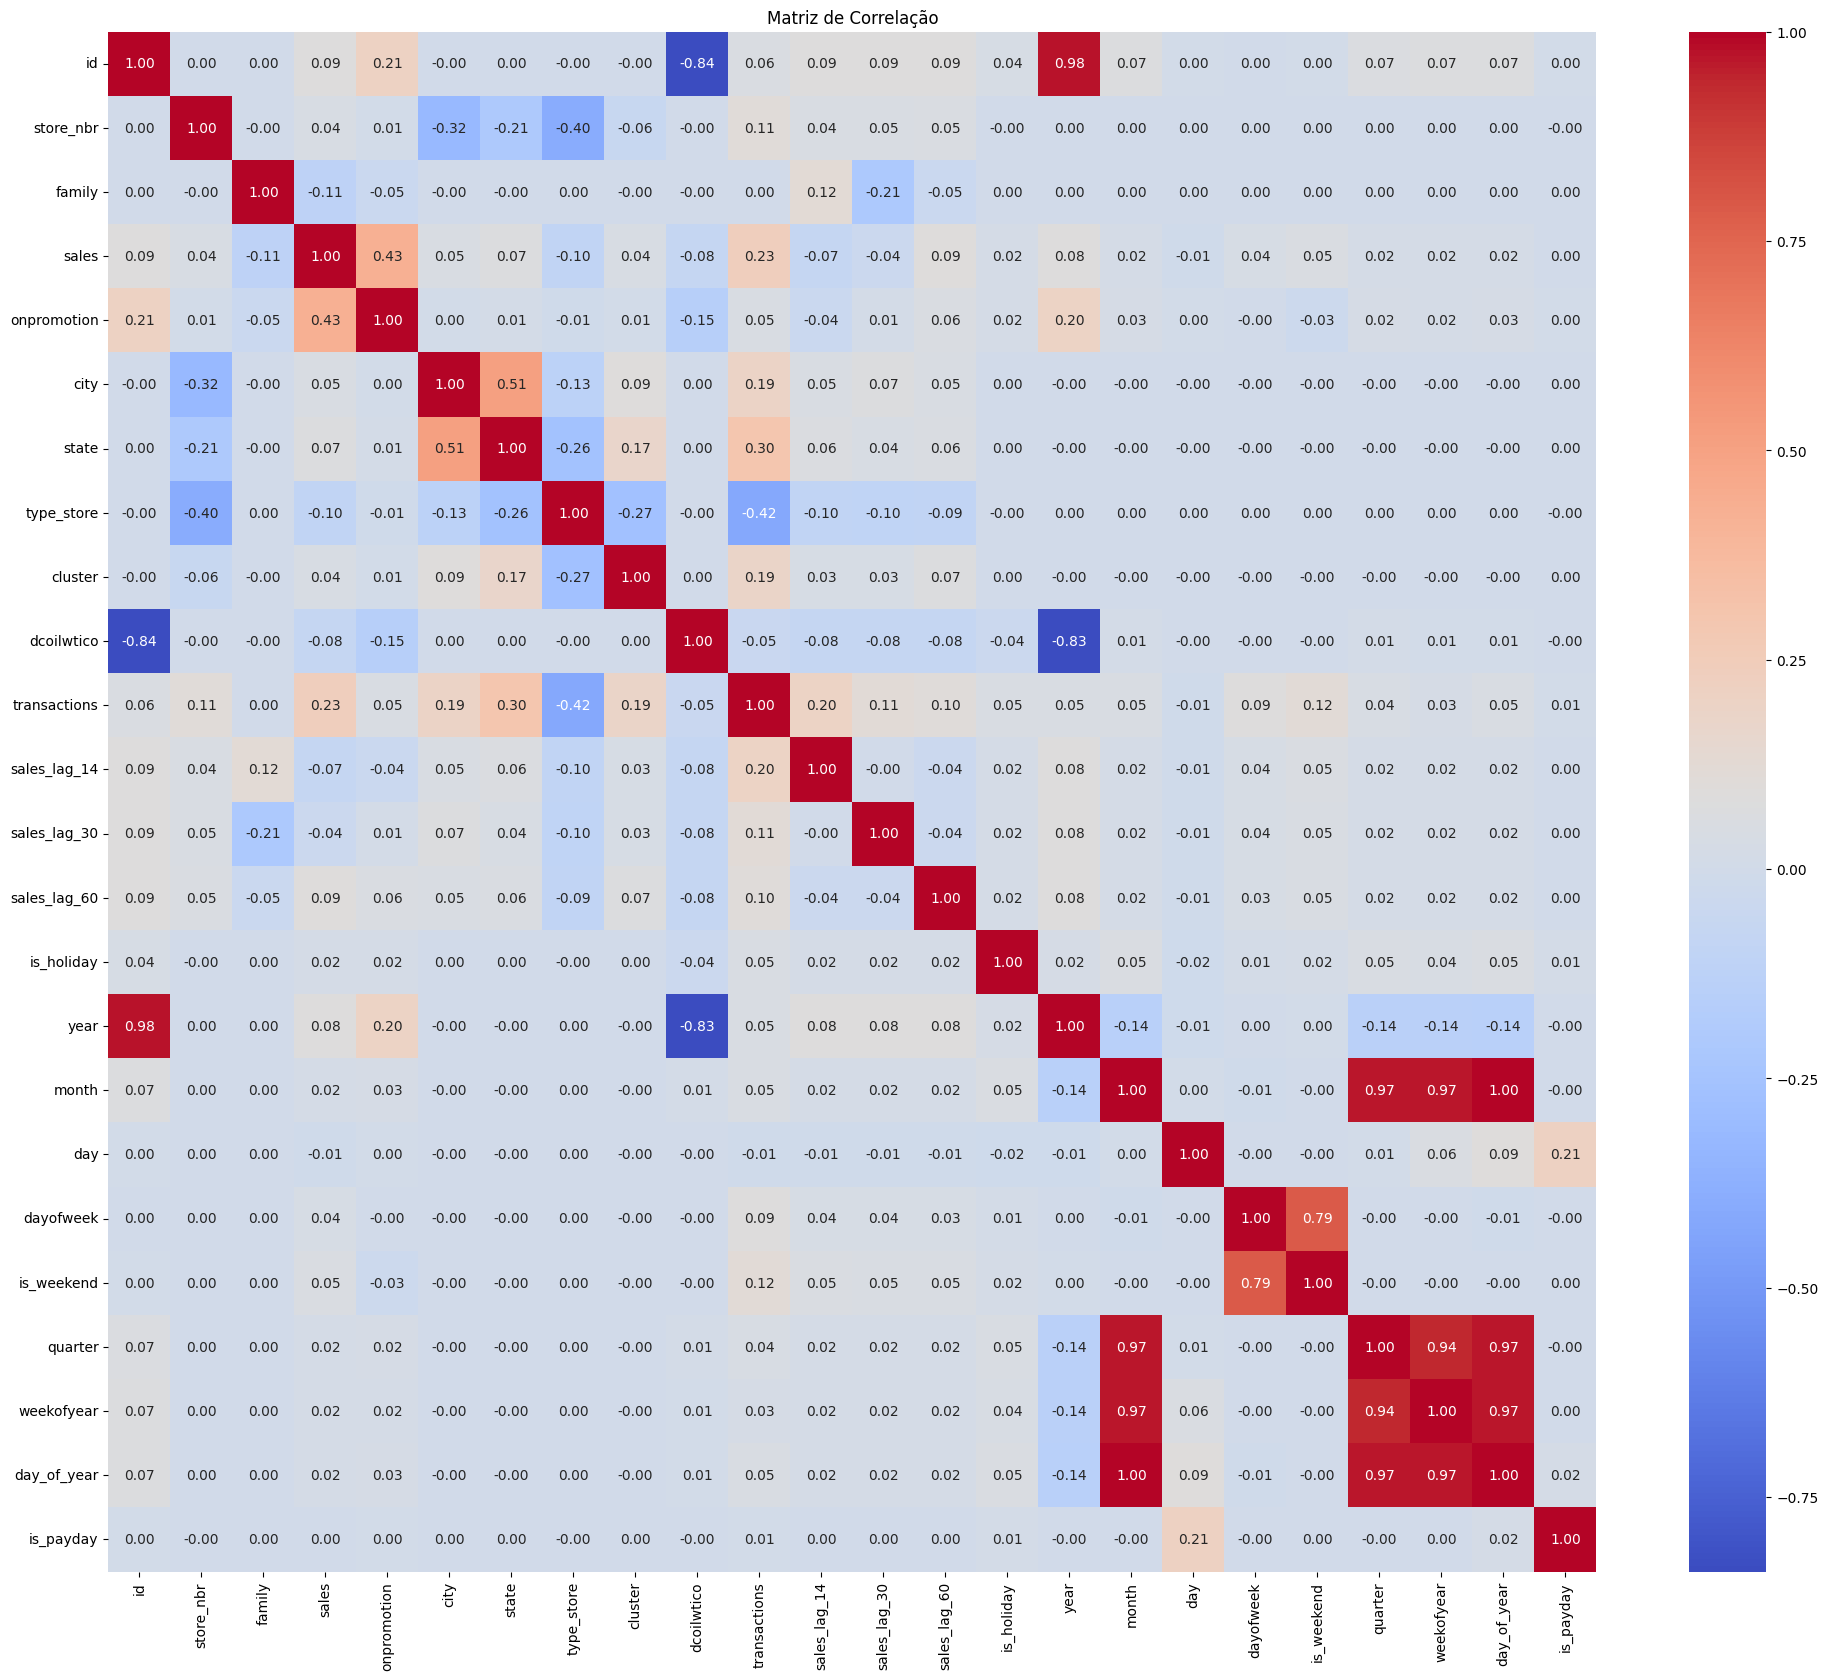

In [117]:
featured_eng_data = train_data.copy()
featured_eng_test_data = test_data.copy()


def add_time_features(df):
  new_df = df.copy()
  new_df['is_holiday'] = new_df['type_holiday'].apply(lambda x: 0 if x in ['No holiday', 'Work Day', 'Transfer'] else 1)
  new_df.drop(columns=['type_holiday', 'locale', 'description'], inplace=True)

  # Criar características de data
  new_df['date'] = pd.to_datetime(new_df['date'])
  new_df['year'] = new_df['date'].dt.year
  new_df['month'] = new_df['date'].dt.month
  new_df['day'] = new_df['date'].dt.day
  new_df['dayofweek'] = new_df['date'].dt.dayofweek
  new_df['is_weekend'] = new_df['date'].dt.dayofweek >= 5
  new_df['quarter'] = new_df['date'].dt.quarter
  new_df['weekofyear'] = new_df['date'].dt.isocalendar().week
  new_df['day_of_year'] = new_df['date'].dt.dayofyear

  # Criar características adicionais
  new_df['is_weekend'] = new_df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
  # Aplicar a função para criar a coluna 'is_payday'
  new_df['is_payday'] = new_df[date_col].apply(is_payday)

  new_df.drop(columns=['date'], inplace=True)

  return new_df

featured_eng_data = add_time_features(featured_eng_data)
featured_eng_test_data = add_time_features(featured_eng_test_data)

# Converter colunas categóricas para valores numéricos
label_encoders = {}
for column in featured_eng_data.select_dtypes(include=[object]).columns:
    label_encoders[column] = LabelEncoder()
    featured_eng_data[column] = label_encoders[column].fit_transform(featured_eng_data[column])
    featured_eng_test_data[column] = label_encoders[column].transform(featured_eng_test_data[column])


# Calcular a matriz de correlação
correlation_matrix = featured_eng_data.corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação')
plt.show()

In [ ]:
# Verificar a presença de NaNs após o merge
print("Número de NaNs no dataframe merged_data após o merge:")
print(featured_eng_data.isna().sum())

# Identificar as linhas com NaNs na coluna transactions
nans_after_merge = featured_eng_data[featured_eng_data['transactions'].isna()]
print("Linhas com NaNs na coluna transactions após o merge:")
print(nans_after_merge)


Número de NaNs no dataframe merged_data após o merge:
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
dcoilwtico         0
transactions       0
is_holiday         0
year               0
month              0
day                0
dayofweek          0
is_weekend         0
quarter            0
weekofyear         0
day_of_year        0
is_end_of_month    0
type_store_A       0
type_store_B       0
type_store_C       0
type_store_D       0
type_store_E       0
cluster_3          0
cluster_5          0
cluster_8          0
cluster_11         0
cluster_14         0
cluster_other      0
dtype: int64
Linhas com NaNs na coluna transactions após o merge:
Empty DataFrame
Columns: [store_nbr, family, sales, onpromotion, city, state, dcoilwtico, transactions, is_holiday, year, month, day, dayofweek, is_weekend, quarter, weekofyear, day_of_year, is_end_of_month, type_store_A, type_store_B, type_store_C, type_store_D, type_st

In [76]:
featured_eng_data.to_csv('/content/drive/MyDrive/coe602/featured_eng_data_lag.csv', index=False)

In [74]:
featured_eng_test_data.to_csv('/content/drive/MyDrive/coe602/featured_eng_test_data_lag.csv', index=False)

In [157]:
featured_eng_data = pd.read_csv('/content/drive/MyDrive/coe602/featured_eng_data_lag.csv')
featured_eng_test_data = pd.read_csv('/content/drive/MyDrive/coe602/featured_eng_test_data_lag.csv')


### parametros pra mexer

In [ ]:
# Calcular a matriz de correlação
# correlation_matrix = featured_eng_data.corr()
# print(correlation_matrix['sales'])

# # Definir um limiar de correlação para clusters importantes
# threshold = 0.05

# # Identificar clusters importantes
# important_clusters = correlation_matrix['sales'][correlation_matrix['sales'].abs() >= threshold].index.tolist()
# important_clusters.remove('sales')

# # Agrupar clusters menos importantes em uma única coluna
# featured_eng_data['cluster_other'] = featured_eng_data[[col for col in featured_eng_data.columns if col.startswith('cluster_') and col not in important_clusters]].sum(axis=1)

# # Manter apenas os clusters importantes e a nova coluna 'cluster_other'
# columns_to_drop = [col for col in featured_eng_data.columns if col.startswith('cluster_') and col not in important_clusters+['cluster_other']]
# featured_eng_data = featured_eng_data.drop(columns=columns_to_drop)

# # One-Hot Encoding para a variável cluster
# featured_eng_test_data = pd.get_dummies(featured_eng_test_data, columns=['cluster'], drop_first=False)

# Agrupar clusters menos importantes em uma única coluna
# important_clusters = ['cluster_3', 'cluster_5', 'cluster_8', 'cluster_11', 'cluster_14']
# featured_eng_test_data['cluster_other'] = featured_eng_test_data[[col for col in featured_eng_test_data.columns if col.startswith('cluster_') and col not in important_clusters]].sum(axis=1)

# # Manter apenas os clusters importantes e a nova coluna 'cluster_other'
# columns_to_drop = [col for col in featured_eng_test_data.columns if col.startswith('cluster_') and col not in important_clusters+['cluster_other']]
# featured_eng_test_data = featured_eng_test_data.drop(columns=columns_to_drop)


# Treino

In [155]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

train_data = featured_eng_data.copy()

features = ['store_nbr', 'family', 'is_holiday', 'dcoilwtico', 'is_payday', 'day', 'month', 'year', 'dayofweek', 'weekofyear', 'is_weekend']
features = ['family', 'sales_lag_60', 'store_nbr', 'sales_lag_14', 'year', 'onpromotion', 'cluster', 'dcoilwtico', 'day_of_year','type_store', 'city', 'dayofweek', 'weekofyear', 'is_holiday', 'is_payday', 'month']
target = 'sales'
id_col = 'id'

# Separar features e target no conjunto de treino
# X = train_data.drop(columns=[target, id_col, 'is_payday', 'quarter'])
X = train_data[features]
y = train_data[target]

# Dividir os dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir os parâmetros para a busca aleatória
param_dist = {
    'num_leaves': sp_randint(20, 50),
    'learning_rate': sp_uniform(0.01, 0.2),
    'n_estimators': sp_randint(100, 1000),
    'max_depth': sp_randint(-1, 20),
    'feature_fraction': sp_uniform(0.6, 0.4),
    'bagging_fraction': sp_uniform(0.6, 0.4),
    'bagging_freq': sp_randint(1, 10),
    'min_child_samples': sp_randint(20, 100)
}

# Inicializar o modelo LightGBM
lgb_model = lgb.LGBMRegressor(objective='tweedie', metric='rmse', boosting_type='gbdt', verbose=-1)

# Configurar a busca aleatória
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_log_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
# Executar a busca aleatória
random_search.fit(X_train, y_train)

# Melhor conjunto de hiperparâmetros
print("Melhores hiperparâmetros encontrados: ", random_search.best_params_)

# Treinar o modelo com os melhores parâmetros
best_lgb_model = random_search.best_estimator_

# Fazer previsões no conjunto de validação
y_val_pred = best_lgb_model.predict(X_val)

# Avaliar o modelo
rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
print(f'RMSLE de validação com os melhores parâmetros: {rmsle_val}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores hiperparâmetros encontrados:  {'bagging_fraction': 0.6783931449676581, 'bagging_freq': 9, 'feature_fraction': 0.9844688097397396, 'learning_rate': 0.1789067697356303, 'max_depth': 11, 'min_child_samples': 72, 'n_estimators': 891, 'num_leaves': 45}
RMSLE de validação com os melhores parâmetros: 0.4630988204704881


In [ ]:
train_data = featured_eng_data.copy()

features = ['store_nbr', 'sales_lag_60', 'family', 'is_holiday', 'dcoilwtico', 'day', 'month', 'year', 'cluster', 'is_payday', 'dayofweek', 'weekofyear', 'is_weekend']
# features = ['family', 'sales_lag_60', 'store_nbr', 'sales_lag_14', 'year', 'onpromotion', 'cluster', 'dcoilwtico', 'day_of_year','type_store','is_weekend', 'city', 'dayofweek', 'weekofyear', 'is_holiday', 'is_payday', 'month', 'day']
# features = ['family', 'sales_lag_60', 'store_nbr', 'sales_lag_14', 'year', 'onpromotion', 'cluster', 'dcoilwtico', 'day_of_year','type_store', 'dayofweek', 'weekofyear', 'is_weekend']
target = 'sales'
id_col = 'id'

# Separar features e target no conjunto de treino
# X = train_data.drop(columns=[target, id_col, 'is_payday', 'quarter'])
X = train_data[features]
y = train_data[target]

# Dividir os dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'objective': 'tweedie', 'metric': 'rmse', 'boosting_type': 'gbdt','bagging_fraction': 0.6783931449676581, 'bagging_freq': 9, 'feature_fraction': 0.9844688097397396, 'learning_rate': 0.1789067697356303, 'max_depth': 11, 'min_child_samples': 72, 'n_estimators': 891, 'num_leaves': 45}
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

lgb_model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, valid_data])

# Fazer previsões no conjunto de validação
y_val_pred = lgb_model.predict(X_val)

# Avaliar o modelo
rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_val_pred))

rmsle_val

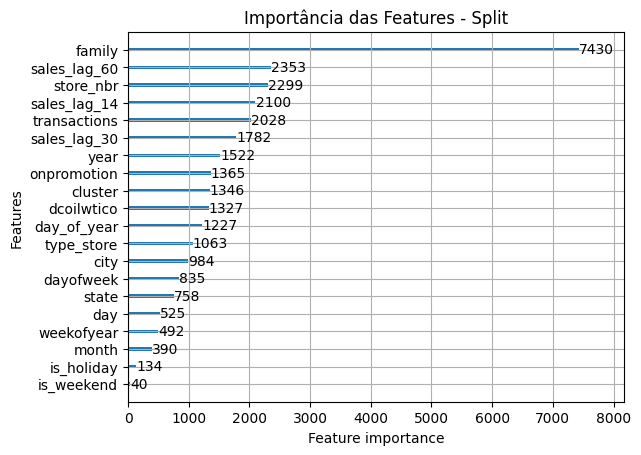

In [134]:
lgb.plot_importance(lgb_model, max_num_features=40, importance_type='split')
plt.title("Importância das Features - Split")
plt.show()

In [159]:
# # Armazenar IDs de teste para submissão
test_data = featured_eng_test_data.copy()
test_ids = test_data[id_col]
X_test = test_data[features]
# X_test = test_data.drop(columns=[target, id_col, 'is_payday', 'quarter'])
y_test_pred = best_lgb_model.predict(X_test)

In [161]:
results = pd.DataFrame({'id':  test_ids, 'sales': y_test_pred})
print(results.head())

        id        sales
0  3000888     4.584969
1  3000889     0.019807
2  3000890     5.999373
3  3000891  2420.808714
4  3000892     0.084439


In [162]:
# Salvar as previsões em um arquivo CSV
csv_path = '/content/drive/MyDrive/coe602/predictions_lgbm.csv'
results.to_csv(csv_path, index=False)
print(f'Results saved to {csv_path}')

Results saved to /content/drive/MyDrive/coe602/predictions_lgbm_3.csv


In [144]:
best_result = pd.read_csv('/content/drive/MyDrive/coe602/predictions_lgbm.csv')


In [145]:
best_result

,id,sales
0,3000888,4.706667
1,3000889,0.036849
2,3000890,4.367208
3,3000891,2799.334303
4,3000892,0.058485
...,...,...
28507,3029395,439.015871
28508,3029396,109.791522
28509,3029397,1350.206207
28510,3029398,27.986379


# **Outros testes realizados**

In [ ]:
featured_eng_data = pd.read_csv('/content/drive/MyDrive/coe602/featured_eng_data.csv')

In [ ]:
# Manter apenas os clusters importantes e a nova coluna 'cluster_other'
columns_to_drop = ['type_store_D', 'sales']
X = featured_eng_data.drop(columns=columns_to_drop)
Y = featured_eng_data['sales']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=42)

# Usar apenas 20% dos dados de treinamento para testes rápidos
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Normalizar os dados
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_sample)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import datetime
inicio = datetime.datetime.now()
print(inicio)

params_lgb = {
    'num_leaves': [31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [0, 1, 5],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 30, 40]
}

lgb_estimator = lgb.LGBMRegressor(objective='regression', metric='rmse', boosting_type='gbdt')

# Usar RandomizedSearchCV para encontrar os melhores parâmetros para LightGBM
rs_lgb = RandomizedSearchCV(
    estimator=lgb_estimator,
    param_distributions=params_lgb,
    n_iter=50,  # Reduzir o número de iterações para testes mais rápidos
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_log_error'
)

rs_lgb.fit(X_train_scaled, y_train_sample)
best_params_lgb = rs_lgb.best_params_
print("Melhores parâmetros LightGBM:", best_params_lgb)

# Treinar o modelo final LightGBM com os melhores parâmetros
model_lgb = lgb.LGBMRegressor(**best_params_lgb,callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ])

model_lgb.fit(scaler.fit_transform(X_train), y_train)
y_pred_lgb = model_lgb.predict(X_test)

# Calcular RMSLE
rmsle_lgb = np.sqrt(mean_squared_log_error(y_test, y_pred_lgb))
print(f'RMSLE LightGBM com RF: {rmsle_lgb}')



print(datetime.datetime.now())
print(datetime.datetime.now() - inicio)

2024-06-05 05:20:45.085045
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan -12.43175735 -12.45551101
          nan -12.0007319  -12.41879717          nan          nan
          nan -11.92921393          nan          nan -12.45599179
          nan          nan -12.13926008 -12.41278237 -11.9158397
 -12.13991932          nan          nan -12.45492121 -11.93324376
          nan          nan          nan -12.41762842          nan
          nan -12.26719935          nan          nan -12.43402633
          nan          nan          nan -12.4121731  -12.46328706
 -12.1462308           nan -12.39591654          nan -12.46515755
 -11.9158397           nan          nan          nan -12.44876682]
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Verificar GPUs disponíveis
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
for gpu in physical_devices:
    print(gpu)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np

inicio = datetime.datetime.now()
print(inicio)

# Função de perda RMSLE personalizada
def rmsle(y_true, y_pred):
    # Adicionar uma pequena constante para evitar log de zero
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    y_true = tf.clip_by_value(y_true, 1e-10, tf.reduce_max(y_true))
    y_pred = tf.clip_by_value(y_pred, 1e-10, tf.reduce_max(y_pred))
    return K.sqrt(K.mean(K.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))

# Carregar os dados
data = featured_eng_data.copy()

# Supondo que os dados tenham uma coluna 'sales' que é a variável alvo
# Dividir os dados em treino e teste
X = data.drop(['sales'], axis=1)
y = data['sales']

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape dos dados para LSTM (samples, time steps, features)
# Aqui, estamos considerando cada amostra como uma sequência completa com um único passo de tempo
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Definir e treinar o modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=20, return_sequences=True, input_shape=(1, X_train.shape[2])))
model_lstm.add(LSTM(units=20))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='relu'))

# Ajustar a taxa de aprendizado
optimizer = Adam(learning_rate=0.001)

model_lstm.compile(loss=rmsle, optimizer=optimizer)

# Adicionar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo LSTM
model_lstm.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

print(datetime.datetime.now())
print(datetime.datetime.now() - inicio)

# Fazer previsões com o modelo LSTM
y_pred_lstm = model_lstm.predict(X_test).flatten()

# Calcular RMSLE para LSTM
rmsle_lstm = rmsle(y_test, y_pred_lstm)
print(f'RMSLE LSTM: {rmsle_lstm}')

print(datetime.datetime.now())
print(datetime.datetime.now() - inicio)

test_data = featured_eng_test_data.copy()
y_pred_test_lstm = model_lstm.predict(test_data).flatten()

# Salvar o modelo
model_path = '/content/drive/MyDrive/coe602/lstm_model2.h5'
model_lstm.save(model_path)
print(f'Model saved to {model_path}')

# Verificar os resultados
results_lstm = pd.DataFrame({'id': test_data['id'].values(), 'prediction_lstm': y_pred_test_lstm})
print(results_lstm.head())


2024-06-05 13:51:49.866946
Epoch 1/100
75207/75207 [==============================] - 341s 4ms/step - loss: 2.0787 - val_loss: 1.8413
Epoch 2/100
75207/75207 [==============================] - 334s 4ms/step - loss: 1.8148 - val_loss: 1.7459
Epoch 3/100
75207/75207 [==============================] - 332s 4ms/step - loss: 1.7555 - val_loss: 1.7318
Epoch 4/100
75207/75207 [==============================] - 331s 4ms/step - loss: 1.7105 - val_loss: 1.6448
Epoch 5/100
75207/75207 [==============================] - 332s 4ms/step - loss: 1.6211 - val_loss: 1.5029
Epoch 6/100
75207/75207 [==============================] - 334s 4ms/step - loss: 1.5014 - val_loss: 1.3903
Epoch 7/100
75207/75207 [==============================] - 334s 4ms/step - loss: 1.3970 - val_loss: 1.3419
Epoch 8/100
75207/75207 [==============================] - 332s 4ms/step - loss: 1.3443 - val_loss: 1.2319
Epoch 9/100
75207/75207 [==============================] - 333s 4ms/step - loss: 1.3102 - val_loss: 1.2133
Epoch 10/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/coe602/lstm_model2.h5


KeyError: 'id'

In [ ]:
# Normalizar os dados de previsão final
test_data_scaled = scaler.transform(test_data)

# Reshape para o formato LSTM
test_data_scaled = test_data_scaled.reshape((test_data_scaled.shape[0], 1, test_data_scaled.shape[1]))

# Fazer previsões com o modelo treinado
y_pred_final = model_lstm.predict(test_data_scaled).flatten()

891/891 [==============================] - 2s 2ms/step


In [ ]:
# Verificar os resultados
X_final = featured_eng_test_data.copy()
results_lstm = pd.DataFrame({'id':  X_final['id'], 'sales': y_pred_final})
print(results_lstm.head())

        id        sales
0  3000888     0.000000
1  3000889     0.000000
2  3000890     0.000000
3  3000891  1294.762085
4  3000892     0.000000


In [ ]:
# Salvar as previsões em um arquivo CSV
csv_path = '/content/drive/MyDrive/coe602/predictions_lstm.csv'
results_lstm.to_csv(csv_path, index=False)
print(f'Results saved to {csv_path}')

Results saved to /content/drive/MyDrive/coe602/predictions_lstm.csv


In [ ]:
len(X_final)

28512

In [ ]:
import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import lightgbm as lgb
from keras.utils import Sequence
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K

inicio = datetime.datetime.now()
print(inicio)

# Gerador de dados para mini-batches
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=128, window_size=7):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.window_size = window_size
        self.indices = np.arange(len(X) - window_size)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = np.array([self.X[i:i + self.window_size] for i in batch_indices])
        y_batch = np.array([self.y[i + self.window_size] for i in batch_indices])
        return X_batch, y_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

def rmsle(y_true, y_pred):
    # Adicionar uma pequena constante para evitar log de zero
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    y_true = tf.clip_by_value(y_true, 1e-10, tf.reduce_max(y_true))
    y_pred = tf.clip_by_value(y_pred, 1e-10, tf.reduce_max(y_pred))
    return K.sqrt(K.mean(K.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))

# Função auxiliar para criar janelas deslizantes
def create_sliding_window(X, y, window_size=7):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

# Normalizar os dados
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Preparar os dados para LSTM usando janelas deslizantes
window_size = 7  # Reduzir o tamanho da janela para 7

# Criar geradores de dados para mini-batches
batch_size = 128
train_generator = DataGenerator(X_train_scaled, y_train.values, batch_size=batch_size, window_size=window_size)
test_generator = DataGenerator(X_test_scaled, y_test.values, batch_size=batch_size, window_size=window_size)

# Definir e treinar o modelo LSTM com menos unidades e menos camadas
model_lstm = Sequential()
model_lstm.add(LSTM(units=20, return_sequences=True, input_shape=(window_size, X_train_scaled.shape[1])))
model_lstm.add(LSTM(units=20))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

# Ajustar a taxa de aprendizado
optimizer = Adam(learning_rate=0.001)

model_lstm.compile(loss=rmsle, optimizer=optimizer)

# Adicionar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo LSTM
model_lstm.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping], verbose=1)


print(datetime.datetime.now())
print(datetime.datetime.now() - inicio)

# Fazer previsões com o modelo LSTM
y_pred_lstm = model_lstm.predict(test_generator).flatten()  # Flatten para converter de (n amostras, 1) para (n amostras,)

# Calcular RMSLE para LSTM
y_test_lstm = np.array([test_generator.y[i + window_size] for i in test_generator.indices[:len(y_pred_lstm)]])
rmsle_lstm =rmsle(y_test_lstm, y_pred_lstm)
print(f'RMSLE LSTM: {rmsle_lstm}')

print(datetime.datetime.now())
print(datetime.datetime.now() - inicio)


2024-06-04 22:45:06.622994
Epoch 1/100
18801/18801 [==============================] - 156s 8ms/step - loss: 2.0053 - val_loss: 1.5066
Epoch 2/100
18801/18801 [==============================] - 156s 8ms/step - loss: 1.3424 - val_loss: 1.3093
Epoch 3/100
18801/18801 [==============================] - 155s 8ms/step - loss: 1.2518 - val_loss: 1.3018
Epoch 4/100
18801/18801 [==============================] - 151s 8ms/step - loss: 1.1505 - val_loss: 1.2712
Epoch 5/100
18801/18801 [==============================] - 151s 8ms/step - loss: 1.0909 - val_loss: 1.1909
Epoch 6/100
18801/18801 [==============================] - 146s 8ms/step - loss: 1.2149 - val_loss: 1.4524
Epoch 7/100
18801/18801 [==============================] - 147s 8ms/step - loss: 1.0075 - val_loss: 1.1696
Epoch 8/100
18801/18801 [==============================] - 151s 8ms/step - loss: 0.8869 - val_loss: 1.1516
Epoch 9/100
18801/18801 [==============================] - 155s 8ms/step - loss: 0.8335 - val_loss: 1.0664
Epoch 10/1

In [ ]:
# Salvar o modelo
model_path = '/content/drive/MyDrive/coe602/lstm_model.h5'
model_lstm.save(model_path)
print(f'Model saved to {model_path}')

Model saved to /content/drive/MyDrive/coe602/lstm_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import backend as K

inicio = datetime.datetime.now()
print(inicio)

# Definir e treinar o modelo CNN com mais unidades e camadas
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(window_size, X_train_scaled.shape[1])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.2))
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))


def rmsle(y_true, y_pred):
    # Adicionar uma pequena constante para evitar log de zero
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    y_true = tf.clip_by_value(y_true, 1e-10, tf.reduce_max(y_true))
    y_pred = tf.clip_by_value(y_pred, 1e-10, tf.reduce_max(y_pred))
    return K.sqrt(K.mean(K.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))


# Ajustar a taxa de aprendizado
optimizer = Adam(learning_rate=0.001)

model_cnn.compile(loss=rmsle, optimizer=optimizer)

# Adicionar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo CNN
model_cnn.fit(train_generator, epochs=50, validation_data=test_generator, callbacks=[early_stopping], verbose=1)

# Fazer previsões com o modelo CNN
y_pred_cnn = model_cnn.predict(test_generator).flatten()  # Flatten para converter de (n amostras, 1) para (n amostras,)

# Calcular RMSLE para CNN
y_test_cnn = np.array([test_generator.y[i + window_size] for i in test_generator.indices[:len(y_pred_cnn)]])
rmsle_cnn = rmsle(y_test_cnn, y_pred_cnn)
print(f'RMSLE CNN: {rmsle_cnn}')

print(datetime.datetime.now())
print(datetime.datetime.now() - inicio)

2024-06-05 00:29:29.838779
Epoch 1/50
18801/18801 [==============================] - 108s 6ms/step - loss: 1.7217 - val_loss: 1.4203
Epoch 2/50
18801/18801 [==============================] - 106s 6ms/step - loss: 1.3356 - val_loss: 1.1124
Epoch 3/50
18801/18801 [==============================] - 106s 6ms/step - loss: 1.1177 - val_loss: 1.0030
Epoch 4/50
18801/18801 [==============================] - 106s 6ms/step - loss: 1.0552 - val_loss: 1.0427
Epoch 5/50
18801/18801 [==============================] - 105s 6ms/step - loss: 1.0156 - val_loss: 1.0010
Epoch 6/50
18801/18801 [==============================] - 106s 6ms/step - loss: 0.9866 - val_loss: 1.0152
Epoch 7/50
18801/18801 [==============================] - 105s 6ms/step - loss: 0.9732 - val_loss: 1.0146
Epoch 8/50
18801/18801 [==============================] - 106s 6ms/step - loss: 0.9607 - val_loss: 0.9552
Epoch 9/50
18801/18801 [==============================] - 105s 6ms/step - loss: 0.9356 - val_loss: 1.0159
Epoch 10/50
18801/1

In [ ]:
# Calcular RMSLE para CNN
y_test_cnn = np.array([test_generator.y[i + window_size] for i in test_generator.indices[:len(y_pred_cnn)]])
rmsle_cnn = rmsle(y_test_cnn, y_pred_cnn)
print(f'RMSLE CNN: {rmsle_cnn}')

RMSLE CNN: 3.5791068077087402


In [ ]:
# Salvar o modelo
model_path = '/content/drive/MyDrive/coe602/cnn_model.h5'
model_cnn.save(model_path)
print(f'Model saved to {model_path}')

Model saved to /content/drive/MyDrive/coe602/cnn_model.h5


In [ ]:
# Definir o espaço de hiperparâmetros
param_dist = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [3, 5, 7, 10],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0]
}

# Instanciar o modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', random_state=42, gpu_id=0)

# Configurar o RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, cv=3, verbose=1, n_jobs=-1, random_state=42, scoring='neg_mean_squared_log_error')

# Executar a busca de hiperparâmetros
random_search.fit(X_train_scaled, y_train_sample)

# Obter os melhores parâmetros
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Treinar o modelo XGBoost com os melhores parâmetros
best_xgb_model = xgb.XGBRegressor(**best_params, tree_method='gpu_hist', gpu_id=0)
best_xgb_model.fit(scaler.fit_transform(X_train), y_train)

# Fazer previsões com o modelo XGBoost
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Função para calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Calcular RMSLE para XGBoost
rmsle_xgb = rmsle(y_test, y_pred_xgb)
print(f'RMSLE XGBoost: {rmsle_xgb}')

# Ensemble - nao terminado

In [ ]:
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model
def rmsle(y_true, y_pred):
    # Adicionar uma pequena constante para evitar log de zero
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    y_true = tf.clip_by_value(y_true, 1e-10, tf.reduce_max(y_true))
    y_pred = tf.clip_by_value(y_pred, 1e-10, tf.reduce_max(y_pred))
    return K.sqrt(K.mean(K.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))


# Carregar os modelos CNN e LSTM treinados com custom_object_scope
with custom_object_scope({'rmsle': rmsle}):
    model_cnn = load_model('/content/drive/MyDrive/coe602/cnn_model.h5')
    model_lstm = load_model('/content/drive/MyDrive/coe602/lstm_model.h5')

# Preparar os dados para LSTM usando janelas deslizantes
window_size = 7  # Reduzir o tamanho da janela para 7

# Criar geradores de dados para mini-batches
batch_size = 128

In [ ]:
# Classe DataGenerator para mini batches sem 'y'
class DataGenerator(Sequence):
    def __init__(self, X, batch_size=128, window_size=7):
        self.X = X
        self.batch_size = batch_size
        self.window_size = window_size
        self.indices = np.arange(len(X) - window_size)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = np.array([self.X[i:i + self.window_size] for i in batch_indices])
        return X_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [ ]:
def create_sliding_windows(X, window_size):
    Xs = []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
    return np.array(Xs)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar os dados
scaler = MinMaxScaler()
columns_to_drop = ['id']
X_test = X_final.drop(columns=columns_to_drop)
X_test_scaled = scaler.fit_transform(X_test)

test_generator = DataGenerator(X_test_scaled, batch_size=batch_size, window_size=window_size)

# Fazer previsões com os modelos CNN e LSTM
y_pred_cnn = predict_with_generator(model_cnn, test_generator)
y_pred_lstm = predict_with_generator(model_lstm, test_generator)
# Parâmetros da janela e batch size
window_size = 7
batch_size = 128

# Função para fazer previsões com o gerador de dados
def predict_with_generator(model, generator):
    predictions = []
    for i in range(len(generator)):
        X_batch = generator[i]  # Corrigido para lidar com o retorno de __getitem__
        batch_predictions = model.predict(X_batch)
        predictions.extend(batch_predictions)
    return np.array(predictions).flatten()

# Fazer previsões com os modelos CNN e LSTM
y_pred_cnn = predict_with_generator(model_cnn, test_generator)
y_pred_lstm = predict_with_generator(model_lstm, test_generator)



4/4 [==============================] - 0s 3ms/step


In [ ]:
# Criar DataFrame para resultados
# ids = test['id'].values
# results_cnn = pd.DataFrame({'id': ids, 'prediction_cnn': y_pred_cnn})
y_pred_cnn

array([-284.3604 , -252.22304, -129.00267, ..., -208.97304, -378.56247,
       -937.3666 ], dtype=float32)

In [ ]:
len(X_test_scaled)

28512

In [ ]:
len(y_pred_cnn)

28416

In [ ]:
y_pred_cnn = model_cnn.predict(test_generator).flatten()
y_pred_lstm = model_lstm.predict(test_generator).flatten()
y_pred_lgb = model_lgb.predict(X_test_scaled)

In [ ]:
from sklearn.linear_model import Ridge

# Combinar as previsões dos três modelos
X_meta_train = np.vstack((y_pred_cnn, y_pred_lstm, y_pred_lgb)).T

# Treinar o meta-modelo (Ridge Regression)
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta_train, y_train.values[:len(X_meta_train)])

# Fazer previsões com o meta-modelo
y_pred_meta = meta_model.predict(X_meta_train)

# Calcular RMSLE para o modelo ensemble
rmsle_ensemble = np.sqrt(mean_squared_log_error(y_test.values[:len(y_pred_meta)], y_pred_meta))
print(f'RMSLE Ensemble: {rmsle_ensemble}')

# Testes realizados

In [ ]:
data = featured_eng_data.copy()

# Dividir os dados em treino e teste
X = data.drop('sales', axis=1)
y = data['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Mean Squared Error: 426773.7543006281
Mean Absolute Error: 293.5049835068862


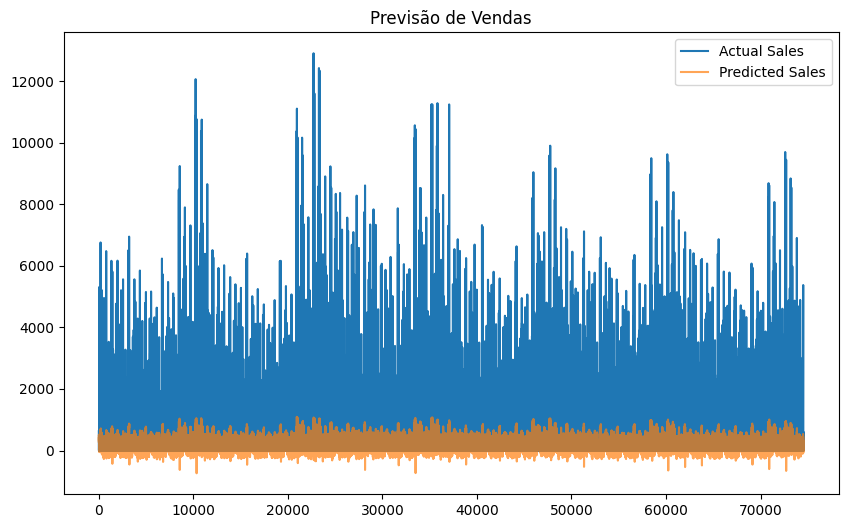

In [ ]:
# Treinar o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales', alpha=0.7)
plt.legend()
plt.title('Previsão de Vendas')
plt.show()

In [ ]:

# Treinar o modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales', alpha=0.7)
plt.legend()
plt.title('Previsão de Vendas')
plt.show()


Mean Squared Error: 46733.47941528238
Mean Absolute Error: 87.53236190790561


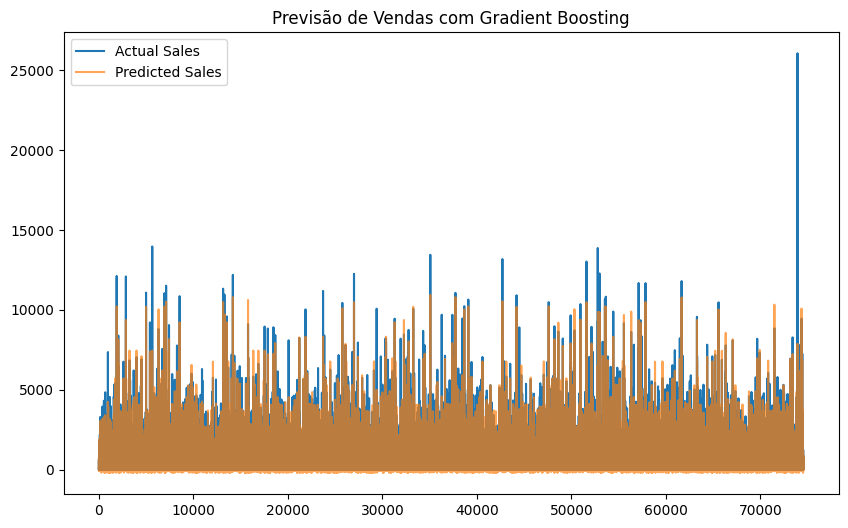

In [ ]:


# Treinar o modelo de Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales', alpha=0.7)
plt.legend()
plt.title('Previsão de Vendas com Gradient Boosting')
plt.show()

In [ ]:
# Calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_value = rmsle(y_test, y_pred)
print(f'RMSLE: {rmsle_value}')

RMSLE: 2.4725033191612877


<ipython-input-29-18d99a4e0c8b>:3: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


DataFrame de treino:
               ds  store_nbr  family  onpromotion  city  state  cluster  \
26423  2013-01-15          5      23            0    21     14        4   
325285 2013-07-02         36       4            0    11      6       10   
15938  2013-01-09          6      32            0    18     12       13   
102773 2013-02-27         42      11            0     3      0        2   
167305 2013-04-04         52      28            0    14     10       11   

        dcoilwtico  transactions  is_holiday  type_store_A  type_store_B  \
26423        93.26        1450.0           0         False         False   
325285       99.65        1049.0           0         False         False   
15938        93.08        1702.0           0         False         False   
102773       92.84           0.0           0         False         False   
167305       93.26           0.0           0          True         False   

        type_store_C  type_store_D  type_store_E       y  
26423       

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpureozdgg/py527wfh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpureozdgg/1yzntowr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31953', 'data', 'file=/tmp/tmpureozdgg/py527wfh.json', 'init=/tmp/tmpureozdgg/1yzntowr.json', 'output', 'file=/tmp/tmpureozdgg/prophet_modelnhnuxywg/prophet_model-20240531221001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



DataFrame de previsão:
          ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2013-01-01  209.823779 -670.002930  1048.551675   209.823779   209.823779   
1 2013-01-01  209.823779 -766.592457  1089.983861   209.823779   209.823779   
2 2013-01-01  209.823779 -747.846922  1029.190858   209.823779   209.823779   
3 2013-01-01  209.823779 -681.511120  1031.832264   209.823779   209.823779   
4 2013-01-01  209.823779 -719.975851  1098.220194   209.823779   209.823779   

   additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
0      -35.164934            -35.164934            -35.164934 -35.164934   
1      -35.164934            -35.164934            -35.164934 -35.164934   
2      -35.164934            -35.164934            -35.164934 -35.164934   
3      -35.164934            -35.164934            -35.164934 -35.164934   
4      -35.164934            -35.164934            -35.164934 -35.164934   

   weekly_lower  weekly_upper  multiplicativ

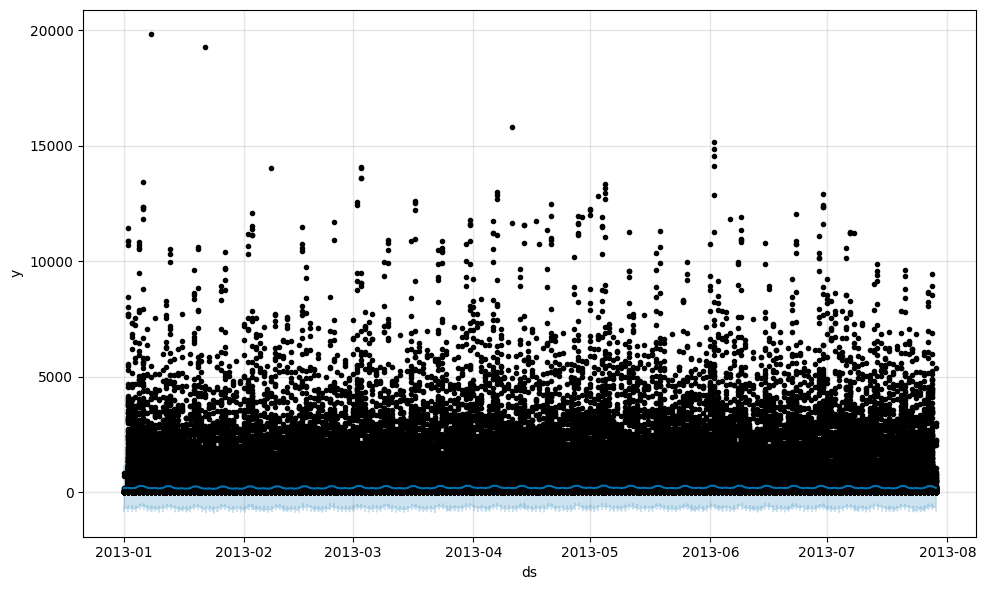

In [ ]:
# !python -m pip install prophet
from prophet import Prophet

# Combinar X_train e y_train para o Prophet
train_data = X_train.copy()
train_data['y'] = y_train

# Renomear a coluna de data para 'ds'
train_data.rename(columns={'date': 'ds'}, inplace=True)

# Verificar o dataframe de treino
print("DataFrame de treino:")
print(train_data.head())

# Instanciar o modelo Prophet
model = Prophet()

# Ajustar o modelo aos dados de treino
model.fit(train_data)

# Preparar X_test para previsão
test_data = X_test.copy()
test_data.rename(columns={'date': 'ds'}, inplace=True)

# Fazer a previsão para o conjunto de teste
forecast = model.predict(test_data)

# Verificar o dataframe de previsão
print("\nDataFrame de previsão:")
print(forecast.head())

# Combinar previsões com y_test para avaliação
forecast['y_true'] = y_test.reset_index(drop=True)

# Calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_value = rmsle(forecast['y_true'], forecast['yhat'])
print(f'RMSLE: {rmsle_value}')

# Visualizar a previsão
fig = model.plot(forecast)
fig.show()


<ipython-input-60-2a6d97678e42>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train2['month'] = data_train2['date'].dt.month


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2656
[LightGBM] [Info] Number of data points in the train set: 298132, number of used features: 24
[LightGBM] [Info] Start training from score 203.487265
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 123.487


<ipython-input-60-2a6d97678e42>:72: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


RMSLE: 2.0792423562875078


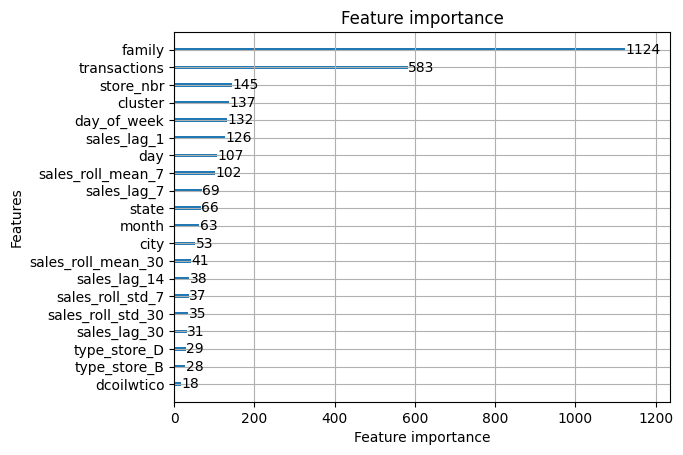

In [ ]:
# Carregar os dados de vendas
data_train2 = data.copy()

# Converter a coluna 'date' para datetime
data_train2['date'] = pd.to_datetime(data_train2['date'])

# Ordenar os dados por data_train2
data_train2 = data_train2.sort_values('date')

# Remover linhas com valores NaN gerados pelas features de lag e rolling window
data_train2 = data_train2.dropna()

# Criar variáveis de data_train2 (mês, dia, dia da semana)
data_train2['month'] = data_train2['date'].dt.month
data_train2['day'] = data_train2['date'].dt.day
data_train2['day_of_week'] = data_train2['date'].dt.dayofweek

# Separar os dados em conjuntos de treinamento e teste
X = data_train2.drop(columns=['date', 'sales'])
y = data_train2['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Treinar um modelo usando LightGBM (como exemplo)
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(params, train_data, valid_sets=[valid_data],     callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ])

# Fazer previsões
y_pred = model.predict(X_test)

# Calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_value = rmsle(y_test, y_pred)
print(f'RMSLE: {rmsle_value}')

# Visualizar a importância das features
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20)
plt.show()

In [ ]:

params = {
    'num_leaves': [31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [0, 1, 5],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 30, 40]
}

lgb_estimator = lgb.LGBMRegressor(objective='regression', metric='rmse', boosting_type='gbdt')

# Usar RandomizedSearchCV para encontrar os melhores parâmetros
rs = RandomizedSearchCV(
    estimator=lgb_estimator,
    param_distributions=params,
    n_iter=100,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train, y_train)

# Melhor combinação de parâmetros
print("Melhores parâmetros:", rs.best_params_)

# Treinar o modelo final com os melhores parâmetros
model = lgb.train(rs.best_params_, train_data, valid_sets=[valid_data],     callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
model = lgb.train(rs.best_params_, train_data, valid_sets=[valid_data],     callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        ])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2656
[LightGBM] [Info] Number of data points in the train set: 298132, number of used features: 24
[LightGBM] [Info] Start training from score 203.487265
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 9299.34


<ipython-input-60-2a6d97678e42>:72: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


RMSLE: 1.5257406793079085


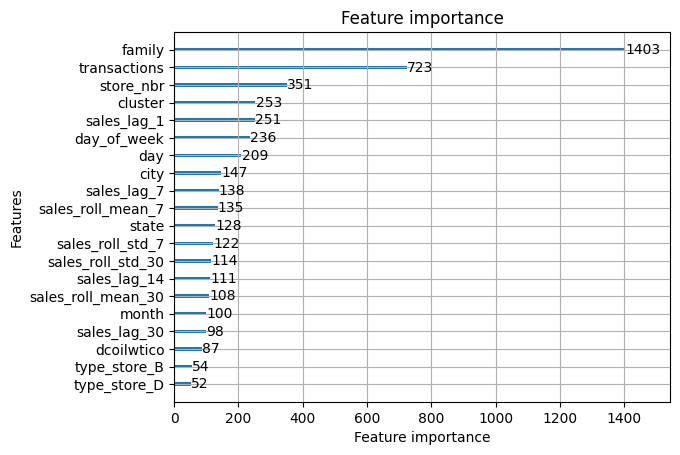

In [ ]:
y_pred = model.predict(X_test)

# Calcular RMSLE
rmsle_value = rmsle(y_test, y_pred)
print(f'RMSLE: {rmsle_value}')

# Visualizar a importância das features
lgb.plot_importance(model, max_num_features=20)
plt.show()

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmsle_scores = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold)

    model = lgb.train(rs.best_params_, train_data, valid_sets=[val_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=100),
                                 ])

    y_pred_fold = model.predict(X_val_fold)
    rmsle_fold = rmsle(y_val_fold, y_pred_fold)
    rmsle_scores.append(rmsle_fold)

print("RMSLE com Cross-Validation:", np.mean(rmsle_scores))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2696
[LightGBM] [Info] Number of data points in the train set: 298132, number of used features: 24
[LightGBM] [Info] Start training from score 203.592144
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 14622.7


<ipython-input-60-2a6d97678e42>:72: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2696
[LightGBM] [Info] Number of data points in the train set: 298133, number of used features: 24
[LightGBM] [Info] Start training from score 203.555745
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 18170.1


<ipython-input-60-2a6d97678e42>:72: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2696
[LightGBM] [Info] Number of data points in the train set: 298133, number of used features: 24
[LightGBM] [Info] Start training from score 203.513351
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 9570.22


<ipython-input-60-2a6d97678e42>:72: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2696
[LightGBM] [Info] Number of data points in the train set: 298133, number of used features: 24
[LightGBM] [Info] Start training from score 203.948277
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 11301.7


<ipython-input-60-2a6d97678e42>:72: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2696
[LightGBM] [Info] Number of data points in the train set: 298133, number of used features: 24
[LightGBM] [Info] Start training from score 204.960222
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 9376.62
RMSLE com Cross-Validation: 1.5855376729876693


<ipython-input-60-2a6d97678e42>:72: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


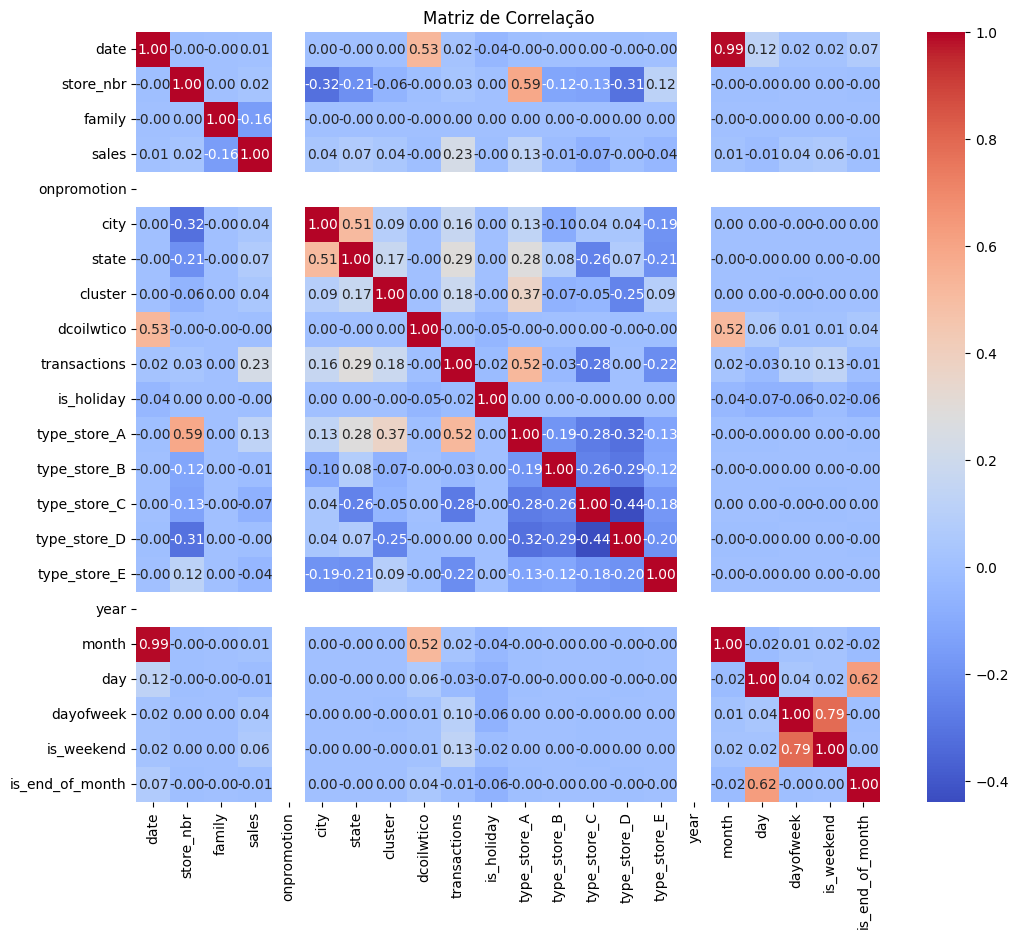

In [ ]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=42)

# Usar apenas 20% dos dados de treinamento para testes rápidos
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Normalizar os dados
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_sample)
X_test_scaled = scaler.transform(X_test)


# Calcular a matriz de correlação
correlation_matrix = featured_eng_data.corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação')
plt.show()

In [ ]:
# Carregar os dados de vendas
data_train = featured_eng_data.copy()
# Separar os dados em conjuntos de treinamento e teste
X = data_train.drop(columns=['date', 'sales'])
y = data_train['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Treinar um modelo usando LightGBM (como exemplo)
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 298132, number of used features: 26
[LightGBM] [Info] Start training from score 203.487265
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 9447.3


<ipython-input-60-2a6d97678e42>:72: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


RMSLE: 1.551020732055903


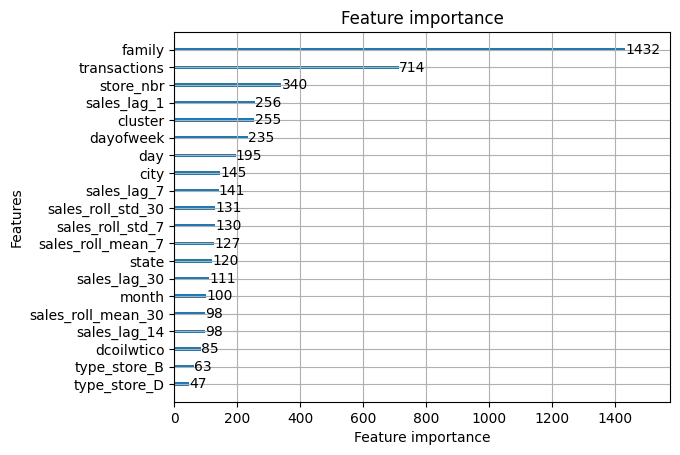

In [ ]:
model = lgb.train(rs.best_params_, train_data, valid_sets=[valid_data],
                  callbacks=[
                      lgb.early_stopping(stopping_rounds=50),
                      ])

y_pred = model.predict(X_test)

# Calcular RMSLE
rmsle_value = rmsle(y_test, y_pred)
print(f'RMSLE: {rmsle_value}')

# Visualizar a importância das features
lgb.plot_importance(model, max_num_features=20)
plt.show()

In [ ]:
# Definir a grid de hiperparâmetros para o RandomizedSearchCV
params = {
    'num_leaves': [31, 40, 50, 60, 70],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1.0],
    'bagging_fraction': [0.8, 0.85, 0.9, 0.95, 1.0],
    'bagging_freq': [0, 1, 2, 5, 10],
    'max_depth': [-1, 10, 20, 30, 40],
    'min_child_samples': [10, 20, 30, 40, 50]
}

lgb_estimator = lgb.LGBMRegressor(objective='regression', metric='rmse', boosting_type='gbdt')

# Usar RandomizedSearchCV para encontrar os melhores parâmetros
rs = RandomizedSearchCV(
    estimator=lgb_estimator,
    param_distributions=params,
    n_iter=100,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train, y_train)

# Melhor combinação de parâmetros
best_params = rs.best_params_
print("Melhores parâmetros:", best_params)

# Treinar o modelo final com os melhores parâmetros
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)
model_lgb = lgb.train(best_params, train_data, valid_sets=[valid_data],
                  callbacks=[
                      lgb.early_stopping(stopping_rounds=50),
                      ])

# Fazer previsões
y_pred = model_lgb.predict(X_test)

# Calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_value = rmsle(y_test, y_pred)
print(f'RMSLE: {rmsle_value}')

# Visualizar a importância das features
lgb.plot_importance(model_lgb, max_num_features=20)
plt.show()

#22 min
joblib.dump(model_lgb, 'model_lgb.pkl')
files.download('model_lgb.pkl')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 298132, number of used features: 26
[LightGB

<ipython-input-86-60c8d742eaa4>:44: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


TypeError: booster must be Booster or LGBMModel.

<ipython-input-86-60c8d742eaa4>:44: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


RMSLE: 1.4275923115138391


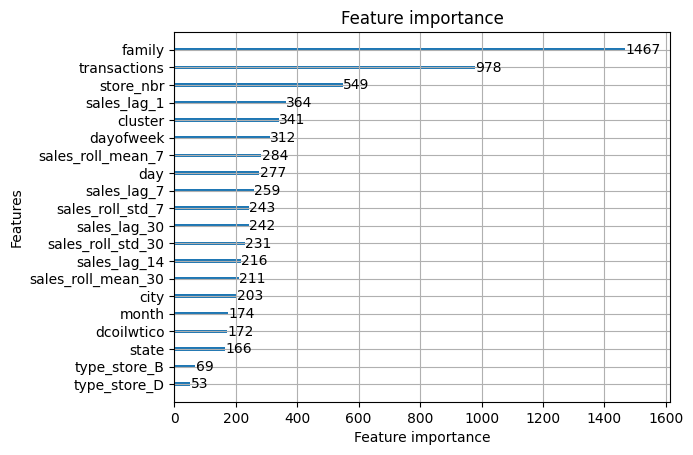

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rmsle_value = rmsle(y_test, y_pred)
print(f'RMSLE: {rmsle_value}')

# Visualizar a importância das features
lgb.plot_importance(model_lgb, max_num_features=20)
plt.show()

joblib.dump(model_lgb, 'model_lgb.pkl')
files.download('model_lgb.pkl')

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7, 9, 11],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5]
}

xgb_estimator = xgb.XGBRegressor(objective='reg:squarederror')

# Usar RandomizedSearchCV para encontrar os melhores parâmetros
gs = RandomizedSearchCV(
    estimator=xgb_estimator,
    param_distributions=params,
    n_iter=100,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

gs.fit(X_train, y_train)

# Melhor combinação de parâmetros
best_params = gs.best_params_
print("Melhores parâmetros:", best_params)

# Treinar o modelo final com os melhores parâmetros
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Calcular RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_value = rmsle(y_test, y_pred)
print(f'RMSLE: {rmsle_value}')


#1h15m
# Visualizar a importância das features
xgb.plot_importance(model, max_num_features=20)
plt.show()

import joblib
from google.colab import files
joblib.dump(model, 'model_xgb.pkl')
files.download('model_xgb.pkl')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
import joblib
from google.colab import files
joblib.dump(model, 'model_xgb.pkl')
files.download('model_xgb.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Step 2: Load the model from Google Drive
import joblib

# Path to the model file in Google Drive
file_path = '/content/drive/My Drive/coe602/model_xgb.pkl'

# Load the model
model = joblib.load(file_path)

# Step 3: Use the model to make predictions
# Example new data
X_new = [[feature1, feature2, feature3, ...]]  # Replace with your actual data

# Make predictions
predictions = model.predict(X_new)

# Print the predictions
print(predictions)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error

def create_sliding_window(X, y, window_size=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - window_size, step):
        Xs.append(X[i:(i + window_size)])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

def evaluate_model(window_size):
    # Preparar os dados
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Criar janela deslizante
    X_train_seq, y_train_seq = create_sliding_window(X_train_scaled, y_train.values, window_size, step=1)
    X_test_seq, y_test_seq = create_sliding_window(X_test_scaled, y_test.values, window_size, step=1)

    # Definir e treinar o modelo GRU
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(window_size, X_train_seq.shape[2])))
    model.add(GRU(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Fazer previsões
    y_pred = model.predict(X_test_seq).flatten()

    # Avaliar o modelo
    mse = mean_squared_error(y_test_seq, y_pred)
    return mse

# Experimentar diferentes tamanhos de janela
window_sizes = [3, 5, 7, 10, 15, 20]
results = {}

for window_size in window_sizes:
    mse = evaluate_model(window_size)
    results[window_size] = mse
    print(f'Tamanho da janela: {window_size}, MSE: {mse}')

# Determinar o tamanho ótimo da janela
optimal_window_size = min(results, key=results.get)

2330/2330 [==============================] - 7s 3ms/step
Tamanho da janela: 3, MSE: 233538.76221165902
2330/2330 [==============================] - 9s 4ms/step
Tamanho da janela: 5, MSE: 235112.27785904304
2329/2329 [==============================] - 10s 4ms/step
Tamanho da janela: 7, MSE: 229434.63520198542
2329/2329 [==============================] - 14s 6ms/step
Tamanho da janela: 10, MSE: 292920.24392713164
2329/2329 [==============================] - 16s 7ms/step
Tamanho da janela: 15, MSE: 269984.51791143365
2329/2329 [==============================] - 20s 8ms/step
Tamanho da janela: 20, MSE: 280978.33565783704


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import GRU, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
import joblib

# Preparar os dados para os modelos GRU e CNN
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, shuffle=False, random_state=42)

# Transformar os dados para a forma [samples, time steps, features]
def create_sequence_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train_seq, y_train_seq = create_sequence_dataset(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequence_dataset(X_test_scaled, y_test, time_steps)

# Definir e treinar o modelo GRU
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])))
model_gru.add(GRU(units=50))
model_gru.add(Dense(1))

model_gru.compile(loss='mean_squared_error', optimizer='adam')
model_gru.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Fazer previsões com o modelo GRU
y_pred_gru = model_gru.predict(X_test_seq).flatten()

# Salvar o modelo GRU
model_gru.save('model_gru.h5')
files.download('model_gru.h5')

# # Definir e treinar o modelo CNN
# model_cnn = Sequential()
# model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, X_train_seq.shape[2])))
# model_cnn.add(MaxPooling1D(pool_size=2))
# model_cnn.add(Flatten())
# model_cnn.add(Dense(50, activation='relu'))
# model_cnn.add(Dense(1))

# model_cnn.compile(loss='mean_squared_error', optimizer='adam')
# model_cnn.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# # Fazer previsões com o modelo CNN
# y_pred_cnn = model_cnn.predict(X_test_seq).flatten()

# # Salvar o modelo CNN
# model_cnn.save('model_cnn.h5')
# files.download('model_cnn.h5')

KeyError: 1172

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Preparar os dados para o modelo LSTM
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, shuffle=False, random_state=42)

# Transformar os dados para a forma [samples, time steps, features]
def create_lstm_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train_lstm, y_train_lstm = create_lstm_dataset(X_train_scaled, y_train, time_steps)
X_test_lstm, y_test_lstm = create_lstm_dataset(X_test_scaled, y_test, time_steps)

# Definir e treinar o modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_train_lstm.shape[2])))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Fazer previsões com o modelo LSTM
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Ajustar o tamanho das previsões do LSTM para coincidir com X_test
y_pred_lstm = y_pred_lstm.flatten()

KeyError: 1172

In [ ]:
# Treinar modelo LightGBM
model_lgb = lgb.train(gs.best_params_, train_data, valid_sets=[valid_data],
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=50),
                      ])
y_pred_lgb = model_lgb.predict(X_test)

# Treinar modelo XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **gs.best_params_)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# Combinar as previsões (simples média)
y_pred_ensemble = (y_pred_lgb + y_pred_xgb) / 2

# Calcular RMSLE do ensemble
rmsle_value_ensemble = rmsle(y_test, y_pred_ensemble)
print(f'RMSLE do Ensemble: {rmsle_value_ensemble}')

NameError: name 'gs' is not defined

In [ ]:
model_lgb_loaded = joblib.load('model_lgb.pkl')
model_xgb_loaded = joblib.load('model_xgb.pkl')
model_xgb_loaded

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.preprocessing import LabelEncoder

data = merged_2.copy()
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data.drop(['id'], axis=1, inplace=True)
data['is_holiday'] = data['type_holiday'].apply(lambda x: 0 if x in ['No holiday', 'Work Day', 'Transfer'] else 1)

# Converter colunas categóricas específicas para one-hot encoding
columns_to_encode = ['type_store']
data = pd.get_dummies(data, columns=columns_to_encode)

# Converter colunas categóricas para valores numéricos
label_encoders = {}
for column in data.select_dtypes(include=[object]).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Criar características de data
data['date'] = pd.to_datetime(data['date'])
# data['year'] = data['date'].dt.year
# data['month'] = data['date'].dt.month
# data['day'] = data['date'].dt.day
# data['dayofweek'] = data['date'].dt.dayofweek

data.drop(columns=['type_holiday', 'locale', 'description', 'date'], inplace=True)

In [ ]:
featured_eng_data = data.copy()
# Criar características de data
featured_eng_data['date'] = pd.to_datetime(featured_eng_data['date'])
featured_eng_data['year'] = featured_eng_data['date'].dt.year
featured_eng_data['month'] = featured_eng_data['date'].dt.month
featured_eng_data['day'] = featured_eng_data['date'].dt.day
featured_eng_data['dayofweek'] = featured_eng_data['date'].dt.dayofweek
data['is_weekend'] = data['date'].dt.dayofweek >= 5
# Criar características adicionais
featured_eng_data['is_weekend'] = featured_eng_data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
featured_eng_data['is_end_of_month'] = featured_eng_data['day'].apply(lambda x: 1 if (x >= 25 or x in [15,16]) else 0)


# Carregar os dados de vendas
data_train3 = featured_eng_data.copy()

# Converter a coluna 'date' para datetime
data_train3['date'] = pd.to_datetime(data_train3['date'])

# Ordenar os dados por data_train3
data_train3 = data_train3.sort_values('date')

# Criar features de lag
def create_lag_features(df, lags):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
    return df

# Criar features de rolling window
def create_rolling_features(df, windows):
    for window in windows:
        df[f'sales_roll_mean_{window}'] = df['sales'].shift(1).rolling(window=window).mean()
        df[f'sales_roll_std_{window}'] = df['sales'].shift(1).rolling(window=window).std()
    return df

# Aplicar as funções para criar features
lags = [1, 7, 14, 30]  # Exemplo de lags
windows = [7, 30]  # Exemplo de janelas de rolling

data_train3 = create_lag_features(data_train3, lags)
data_train3 = create_rolling_features(data_train3, windows)

# Remover linhas com valores NaN gerados pelas features de lag e rolling window
data_train3 = data_train3.dropna()

KeyError: 'sales'

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
import joblib

# Path to the model file in Google Drive
file_path = '/content/drive/My Drive/coe602/model_xgb.pkl'

# Load the model
model = joblib.load(file_path)

# Make predictions
predictions = model.predict(data)

# Print the predictions
print(predictions)


ValueError: feature_names mismatch: ['store_nbr', 'family', 'onpromotion', 'city', 'state', 'cluster', 'dcoilwtico', 'transactions', 'is_holiday', 'type_store_A', 'type_store_B', 'type_store_C', 'type_store_D', 'type_store_E', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'is_end_of_month', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_roll_mean_7', 'sales_roll_std_7', 'sales_roll_mean_30', 'sales_roll_std_30'] ['store_nbr', 'family', 'onpromotion', 'city', 'state', 'cluster', 'dcoilwtico', 'transactions', 'is_holiday', 'type_store_A', 'type_store_B', 'type_store_C', 'type_store_D', 'type_store_E']
expected sales_lag_14, sales_roll_std_30, sales_lag_30, sales_lag_1, day, sales_roll_mean_7, is_weekend, is_end_of_month, month, year, dayofweek, sales_roll_mean_30, sales_lag_7, sales_roll_std_7 in input data